Pre-visualization of the normalized count data

**Need to run first:**
- [`../0-prepare_data`](../0-prepare_data.ipynb)
- [`1-extract_samples`](1-extract_samples.ipynb)
- [`2-run_dge_analysis`](2-run_dge_analysis.ipynb)

**Table of content**

1. [Check samples and genes with normalized counts](#Check-samples-and-genes-with-normalized-counts)
    1. [Check for artefact due to FACS sorting](#Check-for-artefact-due-to-FACS-sorting)
    2. [Check for contamination from other cell types that could have escaped the sorting-gating](#Check-for-contamination-from-other-cell-types-that-could-have-escaped-the-sorting-gating)
2. [Filter contamination genes and contaminated samples](#Filter-contamination-genes-and-contaminated-samples)
1. [Sample-to-sample distance, clustering and PCA](#Sample-to-sample-distance,-clustering-and-PCA)
    1. [Clustering](#Clustering)
        1. [Ward D2](#Ward-D2)
        1. [Kmeans](#Kmeans)
    2. [Sample-to-sample heatmap](#Sample-to-sample-heatmap)
    2. [PCA on the normalized counts](#PCA-on-the-normalized-counts)
        1. [With all factors](#With-all-factors)
        2. [SPF vs GF](#SPF-vs-GF)
3. [Gene co-expression analysis](#Gene-co-expression-analysis)
    1. [Extract modules of co-expressed genes](#Extract-modules-of-co-expressed-genes)
    2. [Relationship between modules and samples](#Relationship-between-modules-and-samples)
    3. [Genes in modules](#Genes-in-modules)
        1. [Heatmaps with Z-scores](#Heatmaps-with-Z-scores)
        2. [Sinaplots of the Z-scores per groups](#Sinaplots-of-the-Z-scores-per-groups)
        3. [Selected genes in modules](#Selected-genes-in-modules)
        4. [Genes related to ROS](#Genes-related-to-ROS)
    4. [Enrichment analysis in modules](#Enrichment-analysis-in-modules)
    
*Generated from a Jupyter Notebook - [Sources](https://github.com/bebatut/neuromac_GF_mices/blob/master/src/microbiota-driven/3-previsualize_data.ipynb)*

# Load

## Libraries and functions

In [1]:
source("../load_libraries.R")

Warning message:
“package ‘reshape2’ was built under R version 3.6.3”
Warning message:
“package ‘XML’ was built under R version 3.6.3”


Allowing multi-threading with up to 4 threads.


Warning message:
“package ‘reshape’ was built under R version 3.6.3”
Warning message:
“package ‘plotly’ was built under R version 3.6.3”
Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Warning message:
“package ‘tibble’ was built under R version 3.6.3”
Warning message:
“package ‘factoextra’ was built under R version 3.6.3”
Warning message:
“package ‘ggrepel’ was built under R version 3.6.3”
preparing gene to GO mapping data...

preparing IC data...

preparing gene to GO mapping data...

preparing IC data...

preparing gene to GO mapping data...

preparing IC data...



In [2]:
source("../functions.R")

## Data

In [3]:
dp = "../../results/dge/microbiota-driven/"
plot_dp = paste(dp, "3-previsualize-data/", sep='')
dir.create(plot_dp, showWarnings = FALSE)

In [4]:
load(paste(dp, "metadata.RData", sep=''))
load(paste(dp, "norm_counts.RData", sep=''))
load(paste(dp, "z_scores.RData", sep=''))

In [5]:
metadata

Microbiota,Age,sample,project
<chr>,<chr>,<chr>,<chr>
GF,Old,GF_104w_M_1_2,S264
GF,Old,GF_104w_M_2_2,S264
GF,Old,GF_104w_M_3_2,S288
GF,Old,GF_104w_M_4_2,S288
GF,Old,GF_104w_M_5_2,S288
GF,Young,GF_8w_M_1_2,S148
GF,Young,GF_8w_M_2_2,S148
GF,Young,GF_8w_M_3_2,S148
GF,Young,GF_8w_M_4_2,S148


In [6]:
trait = list()

i = 'Groups'
trait[[i]] = metadata %>%
    mutate("Young" = as.integer(Age == "Young")) %>%
    mutate("Old" = as.integer(Age == "Old")) %>%
    mutate("SPF" = as.integer(Microbiota == "SPF")) %>%
    mutate("GF" = as.integer(Microbiota == "GF")) %>%
    select(-c(Age, Microbiota, project)) 

i = 'Microbiota / Age'
trait[[i]] = metadata %>%
    mutate("SPF / Young" = as.integer(Microbiota == "SPF" & Age == "Young")) %>%
    mutate("SPF / Old" = as.integer(Microbiota == "SPF" & Age == "Old")) %>%
    mutate("GF / Young" = as.integer(Microbiota == "GF" & Age == "Young")) %>%
    mutate("GF / Old" = as.integer(Microbiota == "GF" & Age == "Old")) %>%
    select(-c(Age, Microbiota, project))

i = 'Age / Microbiota'
trait[[i]] = metadata %>%
    mutate("Young / SPF" = as.integer(Microbiota == "SPF" & Age == "Young")) %>%
    mutate("Young / GF" = as.integer(Microbiota == "GF" & Age == "Young")) %>%
    mutate("Old / SPF" = as.integer(Microbiota == "SPF" & Age == "Old")) %>%
    mutate("Old / GF" = as.integer(Microbiota == "GF" & Age == "Old")) %>%
    select(-c(Microbiota, Age, project))

In [7]:
col_order = list()
annot_col = list()

col_order$ma = metadata %>% arrange(Microbiota) %>% pull(sample)
annot_col$ma = as.data.frame(metadata %>%
    select(c("sample","Age", "Microbiota")) %>%
    mutate(Age = factor(Age, c("Young", "Old"))) %>%
    column_to_rownames('sample'))

col_order$am = metadata %>% arrange(Age) %>% pull(sample)
annot_col$am = as.data.frame(metadata %>%
    select(c("sample", "Microbiota", "Age")) %>%
    mutate(Age = factor(Age, c("Young", "Old"))) %>%
    column_to_rownames('sample'))

annot_colors = list()
annot_colors$Age = c("#ff82ec", "#e2b33a")
names(annot_colors$Age) = c("Young", "Old")
annot_colors$Microbiota = c("#65ce41","#c3a7f9")
names(annot_colors$Microbiota) = c("SPF", "GF")
save(annot_colors, file=paste(dp, "annot_colors.RData", sep=''))

# Check samples and specific genes

## Check for artefact due to FACS sorting

List of genes to check: Egr1, Jun, Zfp36l1, Malat1, Dusp1, Nr4a1, Fos

In [8]:
facs_genes = c('Egr1', 'Jun', 'Zfp36l1', 'Malat1', 'Dusp1', 'Nr4a1', 'Fos')

Normalized counts

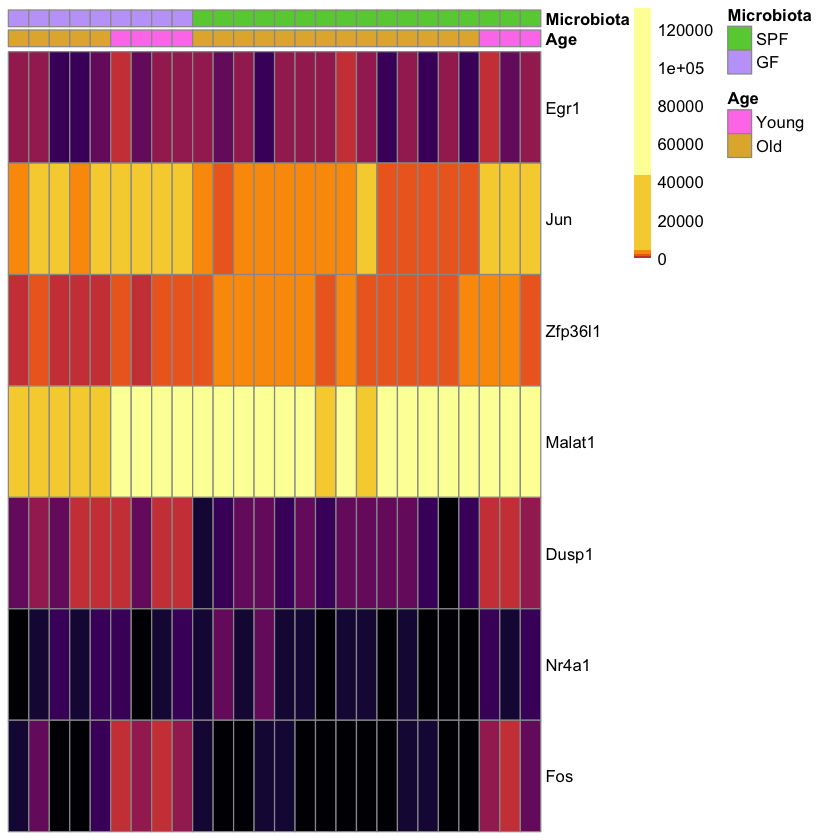

In [9]:
plot_heatmap(norm_counts,
             facs_genes,
             col_order$ma,
             annot_col$ma,
             show_rownames=TRUE)

Z-scores

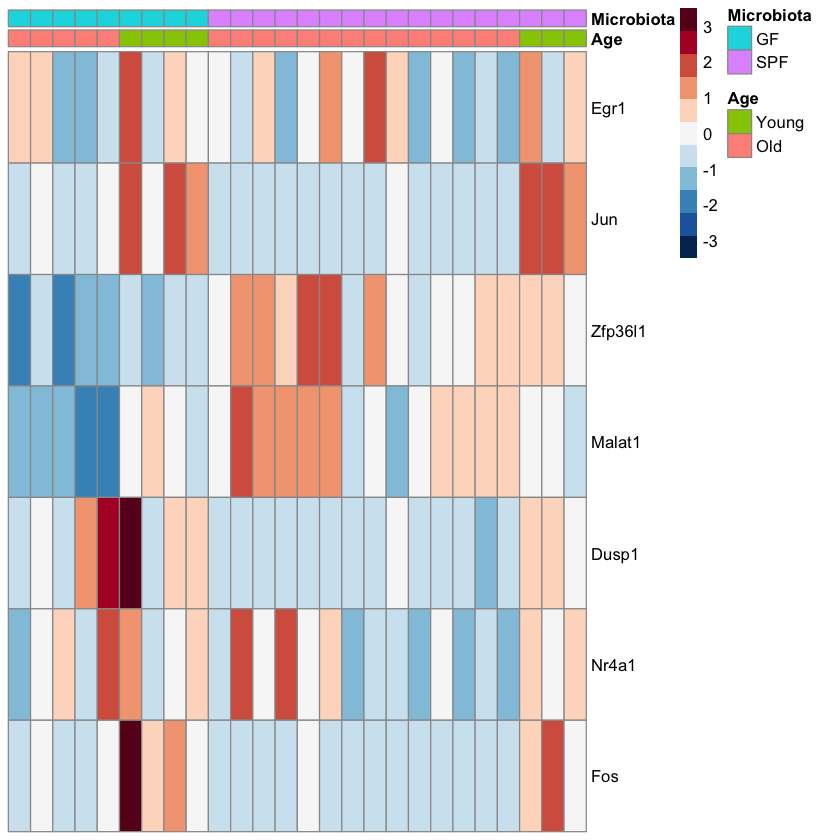

In [10]:
pheatmap(z_scores[facs_genes, col_order$ma],
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_col=as.data.frame(annot_col$ma),
         annotation_row=NULL,
         annotation_colors=NULL,
         color=rev(brewer.pal(11, "RdBu")),
         breaks=seq(-3.5, 3.5, length=12))

## Check for contamination from other cell types that could have escaped the sorting gating

In [11]:
core_signature_genes = list()
core_signature_genes$microglia = c('Tmem119', 'Hexb', 'Scl2a5', 'P2ry12', 'Siglech', 'Trem2', 'P2ry13')
core_signature_genes$macrophage = c('Mrc1', 'Cd163', 'Lyve1', 'Siglec1', 'Pf4')
core_signature_genes$monocyte = c('Ly6c2', 'Ccr2', 'Anxa8', 'Nr4a1', 'Plac8')
core_signature_genes$dc = c('Flt3', 'Zbtb46', 'Itgae', 'Batf3', 'Clec9a')
core_signature_genes$granulocyte = c('Mpo', 'Ngp', 'Wfdc17', 'Ly6g')
core_signature_genes$t = c('Trbc1', 'Trbc2', 'Cd3e', 'Cd3d', 'Nkg7')
core_signature_genes$b= c('Cd79a', 'Igkc', 'Ighm', 'Cd19', 'Ebf1')
core_signature_genes$mast = c('Tpsb2', 'Mcpt4', 'Cma1', 'Cpa3')
core_signature_genes$nk = c('NKp46', 'NK1.1', 'NKG2D', 'Gzmb', 'Eomes', 'Tbet')
core_signature_gene_df = melt(core_signature_genes) %>%
    rename(genes = value) %>%
    rename(cell = L1)
removed_genes = core_signature_gene_df %>%
    filter(!(genes %in% rownames(z_scores)))
core_signature_gene_df = core_signature_gene_df %>%
    filter(genes %in% rownames(z_scores))
core_signature_gene_df

genes,cell
<chr>,<chr>
Tmem119,microglia
Hexb,microglia
P2ry12,microglia
Siglech,microglia
Trem2,microglia
P2ry13,microglia
Mrc1,macrophage
Cd163,macrophage
Lyve1,macrophage


Genes in list, but not in the counts

In [12]:
removed_genes

genes,cell
<chr>,<chr>
Scl2a5,microglia
Anxa8,monocyte
Ly6g,granulocyte
Trbc1,t
Trbc2,t
Cd3d,t
Igkc,b
Ighm,b
Mcpt4,mast


Normalized counts

In [13]:
cell_annot_colors = annot_colors
cell_annot_colors$Cell = c("#56a4d0", "#d5682b", "#7b6fcb", "#a49f3d", "#c356b8", "#59a85f", "#d04659", "#b7794a", "#c0668e")
names(cell_annot_colors$Cell) = c("microglia", "macrophage", "monocyte", "dc", "granulocyte", "t", "b", "mast", "nk")

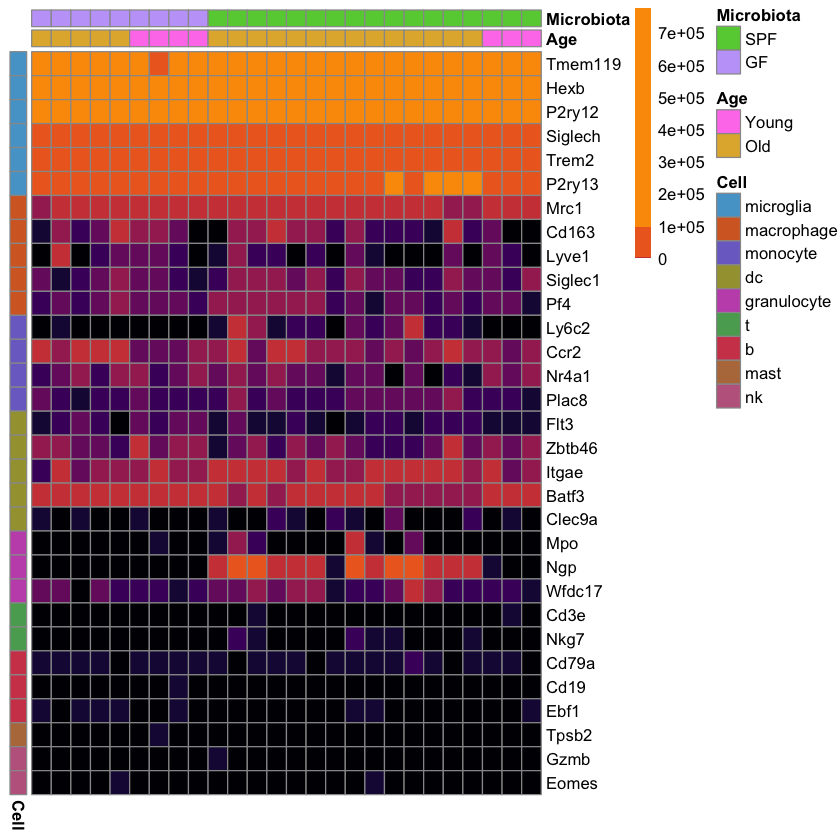

In [14]:
data = norm_counts[as.vector(core_signature_gene_df$genes), col_order$ma]
breaks = quantile_breaks(data, n = 11)
pheatmap(data,
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_colors=cell_annot_colors,
         annotation_col=annot_col$ma,
         annotation_row=data.frame(Cell=core_signature_gene_df$cell, row.names=core_signature_gene_df$genes),
         breaks=breaks,
         color=inferno(10))
pheatmap(data,
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_colors=cell_annot_colors,
         annotation_col=annot_col$ma,
         annotation_row=data.frame(Cell=core_signature_gene_df$cell, row.names=core_signature_gene_df$genes),
         breaks=breaks,
         color=inferno(10),
         filename=paste(plot_dp, "cell_type_gene_norm_counts.pdf", sep=''))

Z-score

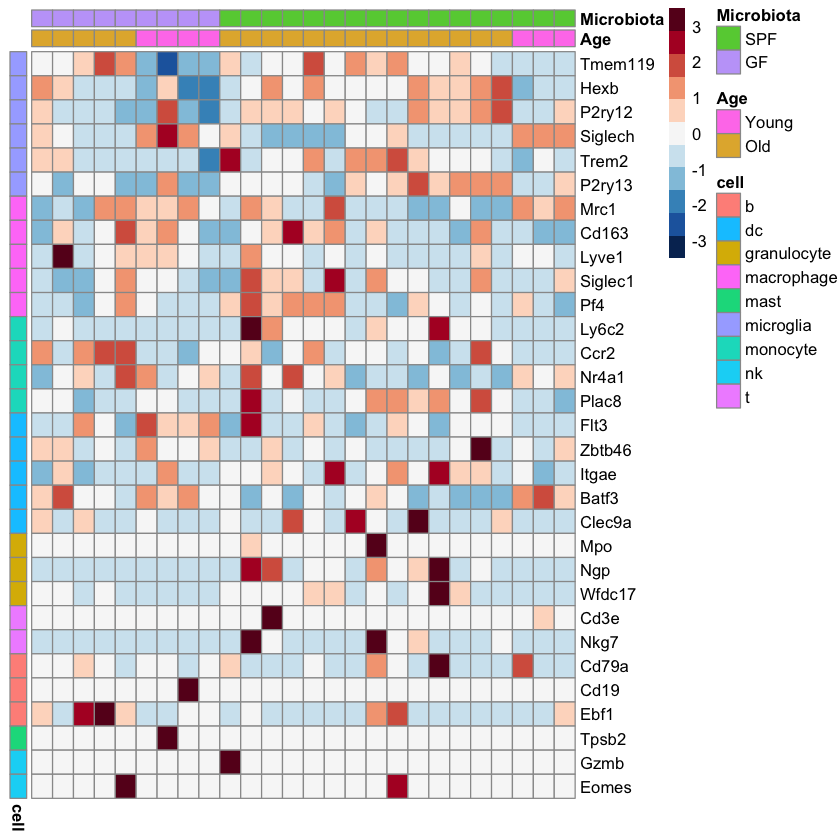

In [15]:
pheatmap(z_scores[as.vector(core_signature_gene_df$genes), col_order$ma],
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_col=annot_col$ma,
         annotation_row=data.frame(cell=core_signature_gene_df$cell, row.names=core_signature_gene_df$genes),
         annotation_colors = cell_annot_colors,
         color=rev(brewer.pal(11, "RdBu")),
         breaks = seq(-3.5, 3.5, length=12))

# Filter contamination genes and contaminated samples

Genes that could be artefact due to FACS sorting or contamination from other cell types and samples that seem contaminated: 'GF_8w_M_2_2', 'SPF_52w_F_1_2', 'SPF_104w_M_3_2'

In [16]:
potentially_contaminated_samples = c('SPF_52w_F_1_2', 'SPF_104w_M_3_2')

Filter the normalized counts (value before and )

In [17]:
original_norm_counts = norm_counts
norm_counts = data.frame(norm_counts) %>%
    rownames_to_column('genes') %>%
    filter(!genes %in% facs_genes) %>%
    filter(!genes %in% core_signature_genes$macrophage) %>%
    filter(!genes %in% core_signature_genes$monocyte) %>%
    filter(!genes %in% core_signature_genes$dc) %>%
    filter(!genes %in% core_signature_genes$granulocyte) %>%
    filter(!genes %in% core_signature_genes$t) %>%
    filter(!genes %in% core_signature_genes$b) %>%
    filter(!genes %in% core_signature_genes$mast) %>%
    filter(!genes %in% core_signature_genes$nk) %>% 
    filter(!genes %in% core_signature_genes$nk) %>% 
    select(-c(SPF_104w_M_3_2)) %>%
    filter_at(vars(-genes), any_vars(. > 0)) %>%
    column_to_rownames('genes')
dim(original_norm_counts)[1]-dim(norm_counts)[1]
save(norm_counts, file=paste(dp, "filtered_norm_counts.RData", sep=''))
write.table(norm_counts, paste(dp, "filtered_norm_counts", sep=''), sep = "\t", quote = FALSE)

[1] 65

In [18]:
mean_counts = apply(norm_counts, 1, mean)
sd_counts = apply(norm_counts, 1, sd)
z_scores = (norm_counts - mean_counts)/sd_counts
save(z_scores, file=paste(dp, "filtered_z_scores.RData", sep=''))
write.table(z_scores, paste(dp, "filtered_z_scores", sep=''), sep = "\t", quote = FALSE)

Filter the samples from annotations and metadata

In [19]:
for(i in 1:length(trait)){
    trait[[i]] = trait[[i]] %>%
        filter(!sample %in% potentially_contaminated_samples)
}
save(trait, file=paste(dp, "trait.RData", sep=''))

In [20]:
col_order = lapply(col_order, function(x) return(x[!x %in% potentially_contaminated_samples]))
annot_col = lapply(annot_col, function(x) return(x[!rownames(x) %in% potentially_contaminated_samples,]))
save(col_order, file=paste(dp, "col_order.RData", sep=''))
save(annot_col, file=paste(dp, "annot_col.RData", sep=''))

In [21]:
metadata = metadata %>%
    filter(!sample %in% potentially_contaminated_samples)
save(metadata, file=paste(dp, "filtered_metadata.RData", sep=''))

In [22]:
all_deg_genes = c()
save(all_deg_genes, file=paste(dp, "all_deg_genes.RData", sep=''))

# Sample-to-sample distance, clustering and PCA

In [23]:
sample_dist = t(norm_counts) %>% dist
sample_dist_matrix = as.matrix(sample_dist)

In [25]:
list_colors = unlist(annot_colors)
names(list_colors) = gsub("(Microbiota|Age)\\.","",names(list_colors))
colors = metadata %>%
         mutate(Age = gsub("Old", list_colors['Old'], Age)) %>%
         mutate(Age = gsub("Young", list_colors['Young'], Age)) %>%
         mutate(Microbiota = gsub("SPF", list_colors['SPF'], Microbiota)) %>%
         mutate(Microbiota = gsub("GF", list_colors['GF'], Microbiota)) %>%
         select(c("Age", "Microbiota", "sample")) %>%
         column_to_rownames('sample')
plot_clustering_tree = function(sampleTree) {
    par(mar = c(4,4,1,1))
    par(cex = 0.6)
    plot(sampleTree, leaflab="none")
    colored_bars(colors, sampleTree, rowLabels=colnames(colors), y_shift=0.5)
    legend("topright", fill=unlist(list_colors), names(list_colors), cex=0.7)
}

## Clustering

### Ward D2

In [26]:
sample_clust = sample_dist %>% hclust(method = "ward.D2") 

pdf 
  2

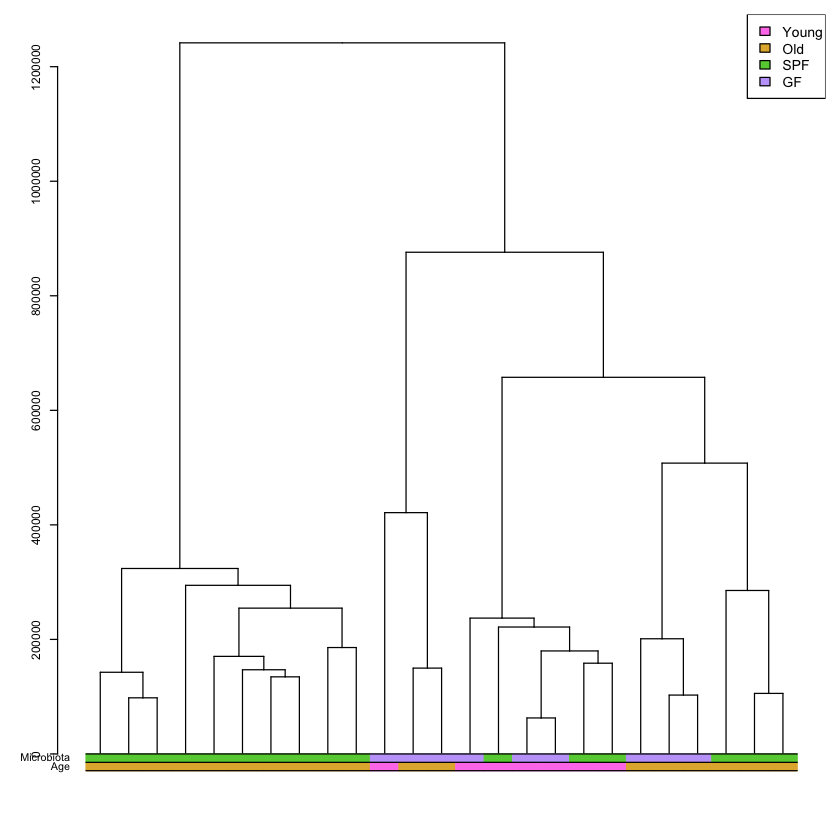

In [27]:
sample_clust_tree = sample_clust %>% as.dendrogram
plot_clustering_tree(sample_clust_tree)
pdf(paste(plot_dp, "dendogram.pdf", sep=''))
plot_clustering_tree(sample_clust_tree)
dev.off()

#### Without X/Y genes

Extract genes from chrX / chrX_GL456233_random / chrY

In [28]:
annot = read.table("../../data/mm10_UCSC_07_15_genes.gtf", sep="\t")
chrX_chrY_genes = annot %>% 
  filter(V1 == 'chrX' | V1 == 'chrX_GL456233_random' | V1 == 'chrY') %>%
  select(V9) %>%
  tidyr::separate(V9, into = c("v1", "gene_id", "v2", "gene_name", "v3", "p_id", "v4", "transcript_id", "v5", "tss_id"), sep = " |;") %>%
  select(gene_id) %>%
  distinct() %>%
  pull(gene_id)
length(chrX_chrY_genes)

Warning message:
“Expected 10 pieces. Additional pieces discarded in 30003 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


[1] 1120

Remove genes (number displayed) from the count table

In [29]:
chrX_chrY_counts = norm_counts %>%
    rownames_to_column('genes') %>%
    filter(genes %in% chrX_chrY_genes)
dim(chrX_chrY_counts)[1]
non_chrX_chrY_counts = norm_counts %>%
    rownames_to_column('genes') %>%
    filter(!genes %in% chrX_chrY_genes) %>%
    column_to_rownames('genes')

[1] 625

Clustering method: Ward D2

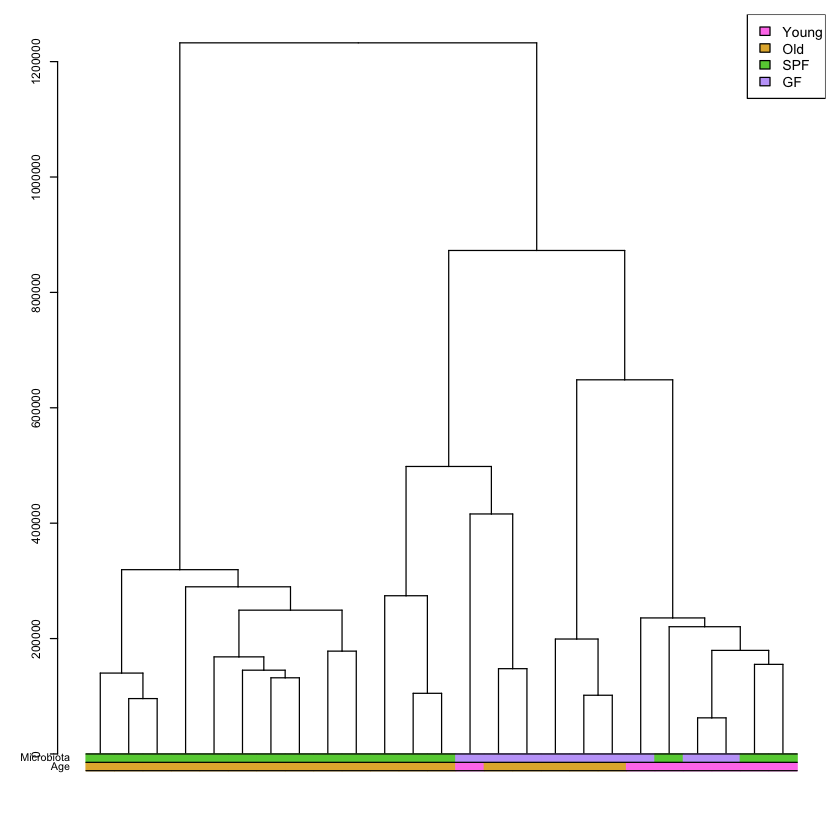

In [30]:
sampleTree = t(non_chrX_chrY_counts) %>% dist %>% hclust(method = "ward.D2") %>% as.dendrogram
plot_clustering_tree(sampleTree)

### Kmeans

Elbow method to compute the number of cluster

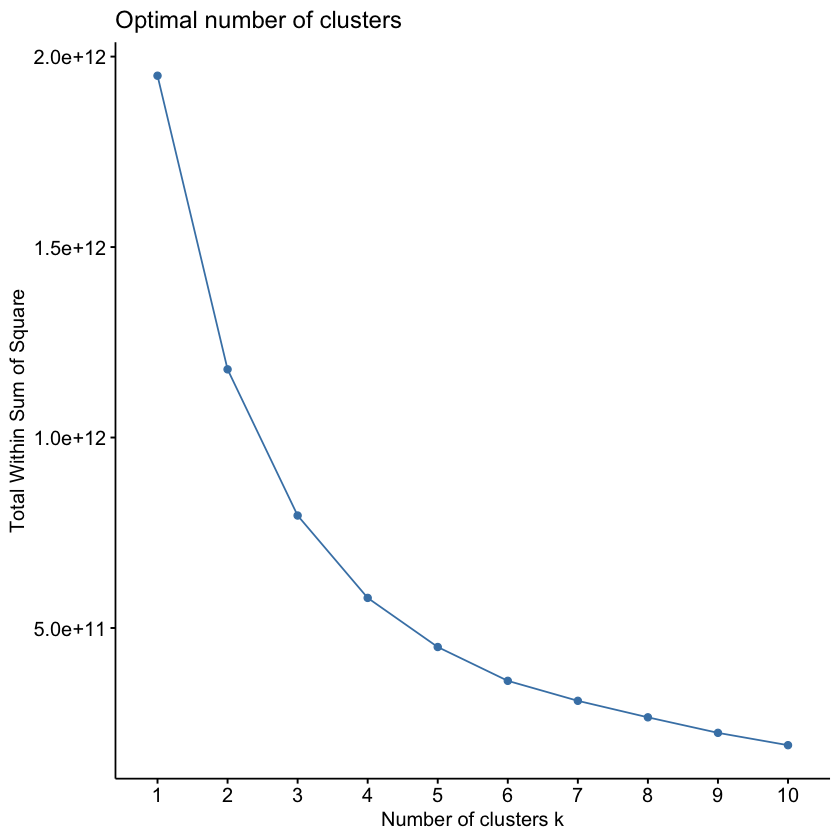

In [31]:
fviz_nbclust(t(norm_counts), diss=sample_dist, FUN=hcut, method="wss")

Average silhouette method to compute the number of cluster


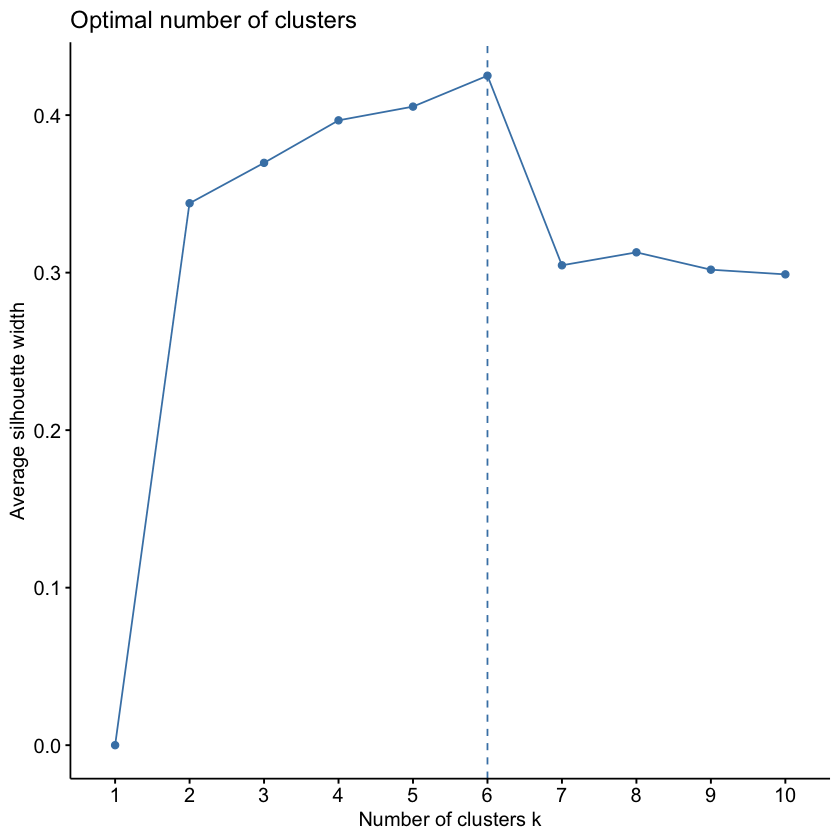

In [32]:
fviz_nbclust(t(norm_counts), diss=sample_dist, FUN=hcut, method="silhouette")

##### kmeans with 3 clusters

In [38]:
sample_clust_km = kmeans(sample_dist, 6)

Within cluster sum of square (*how similar each individual, within the cluster are. The smaller the number, the more similar inidivduals are*)

In [39]:
sample_clust_km$withinss

[1] 635813432058 527143806994            0 230508520516 355663190545
[6] 127062942295

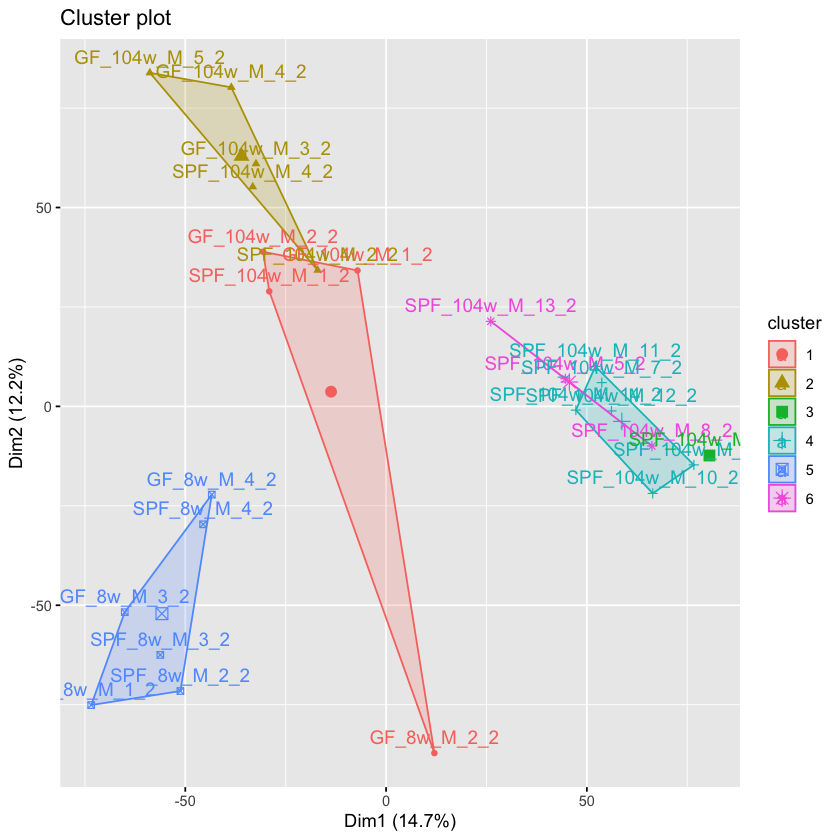

In [40]:
fviz_cluster(sample_clust_km, t(norm_counts))

In [41]:
clust_metadata = metadata %>%
    select(-project) %>%
    add_column(Cluster = as.factor(sample_clust_km$cluster)) %>%
    column_to_rownames('sample')
clust_size = count(clust_metadata, Cluster) %>%
    rename( Total = n)

In [42]:
count(clust_metadata, Cluster, Microbiota) %>% 
    spread(Microbiota, n, fill = 0) %>%
    full_join(clust_size, by='Cluster')
count(clust_metadata, Cluster, Age) %>% 
    spread(Age, n, fill = 0) %>%
    full_join(clust_size, by='Cluster')

Cluster,GF,SPF,Total
<fct>,<dbl>,<dbl>,<int>
1,3,1,4
2,3,2,5
3,0,1,1
4,0,6,6
5,3,3,6
6,0,3,3


Cluster,Old,Young,Total
<fct>,<dbl>,<dbl>,<int>
1,3,1,4
2,5,0,5
3,1,0,1
4,6,0,6
5,0,6,6
6,3,0,3


In [43]:
count(clust_metadata, Cluster, Microbiota, Age) %>%
    mutate(SA = paste(Microbiota, Age, sep=' - ')) %>%
    select(-c(Microbiota, Age)) %>%
    spread(SA, n, fill = 0) %>%
    full_join(clust_size, by='Cluster')

Cluster,GF - Old,GF - Young,SPF - Old,SPF - Young,Total
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2,1,1,0,4
2,3,0,2,0,5
3,0,0,1,0,1
4,0,0,6,0,6
5,0,3,0,3,6
6,0,0,3,0,3


## Sample-to-sample heatmap

Ward D2 clustering for the rows and cols

pdf 
  2

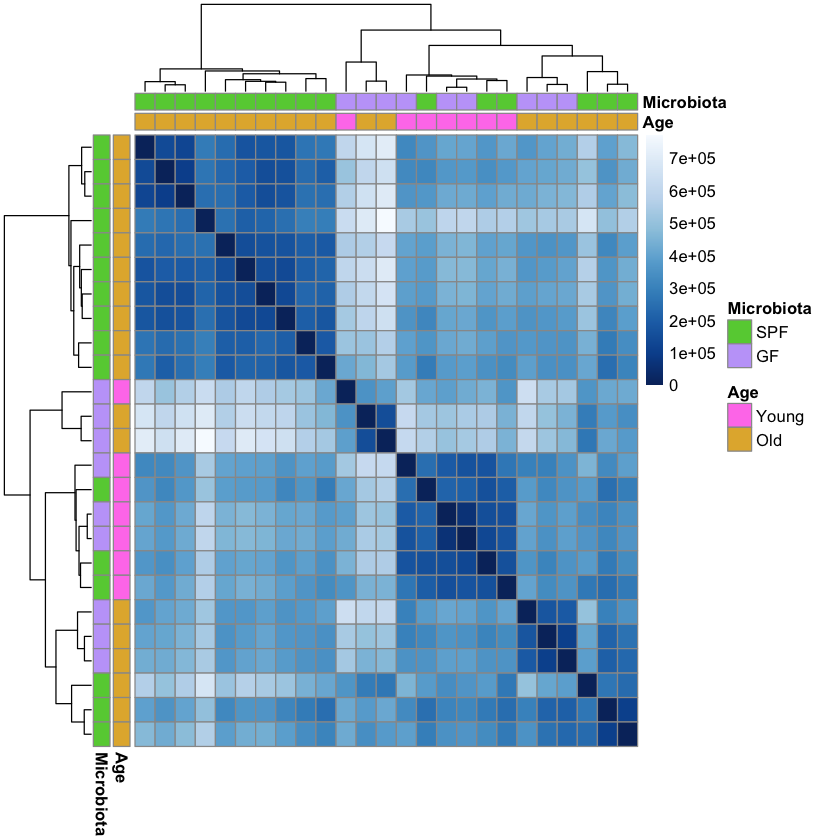

In [44]:
xx = pheatmap(sample_dist_matrix,
         show_rownames=F,
         show_colnames=F,
         cluster_cols=sample_clust,
         cluster_rows=sample_clust,
         annotation_col=annot_col$ma,
         annotation_row=annot_col$ma,
         annotation_colors=annot_colors,
         col=colorRampPalette(rev(brewer.pal(9, "Blues")))(255))
pdf(paste(plot_dp, "sample_sample_heatmap.pdf", sep=''))
grid::grid.newpage()
grid::grid.draw(xx$gtable)
dev.off()

## PCA on the normalized counts

### With all factors

In [45]:
pca_data = t(norm_counts)

#### PC1 and PC2

With color to differentiate the groups

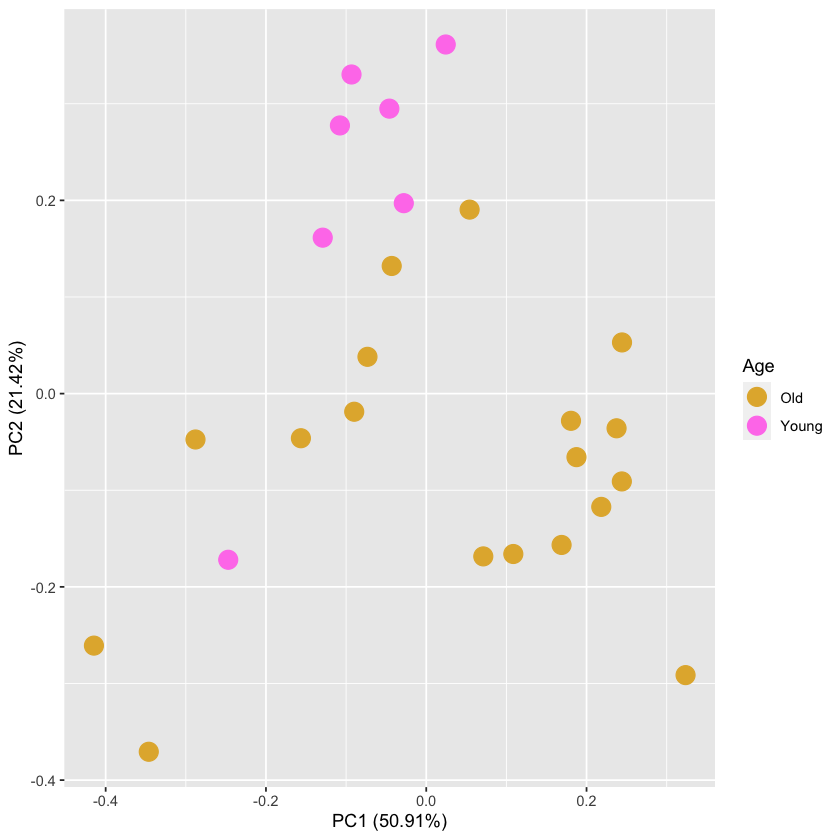

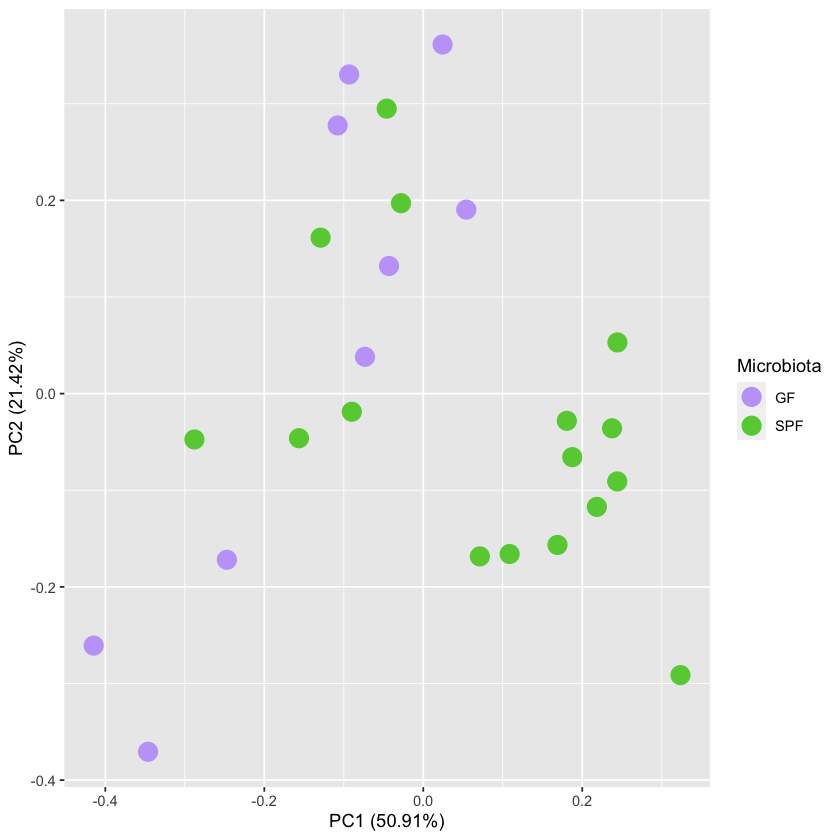

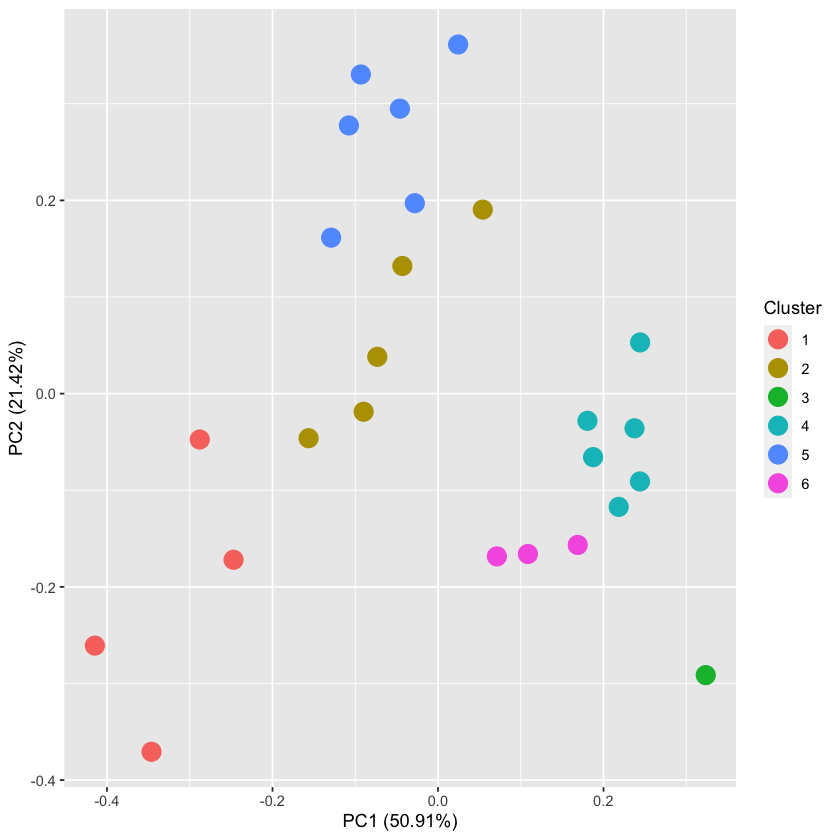

In [46]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', size = 5) + 
    scale_color_manual(values = annot_colors$Age)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Microbiota', size = 5) + 
    scale_color_manual(values = annot_colors$Microbiota)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', size = 5)

With form to differentiate the groups and color for the clusters

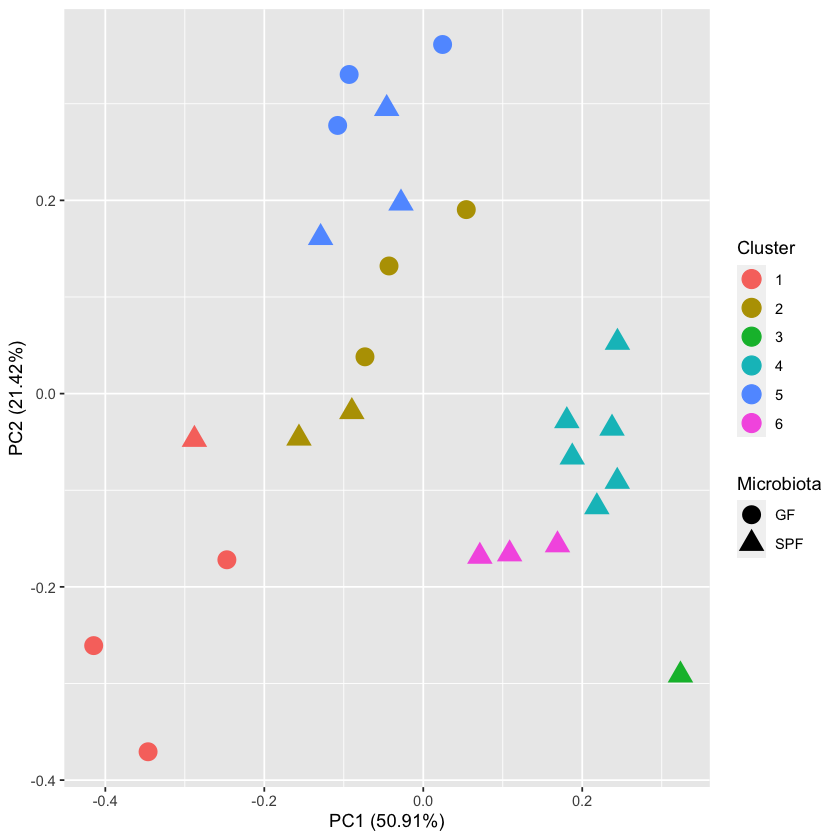

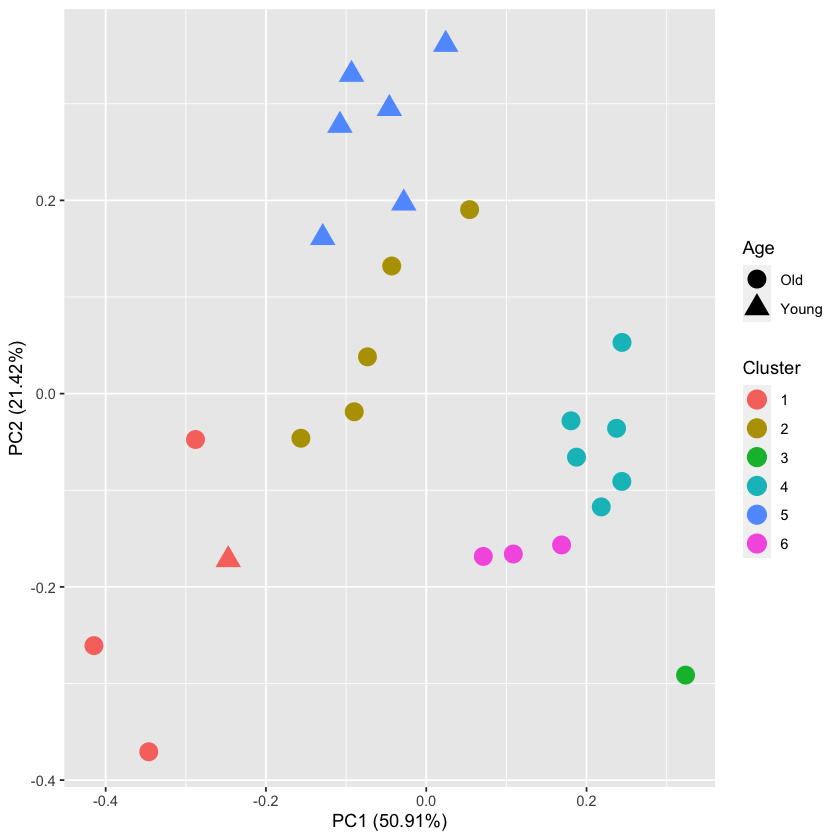

In [47]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', shape='Microbiota', size = 5)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', shape='Age', size = 5)

With color and form to differentiate the groups

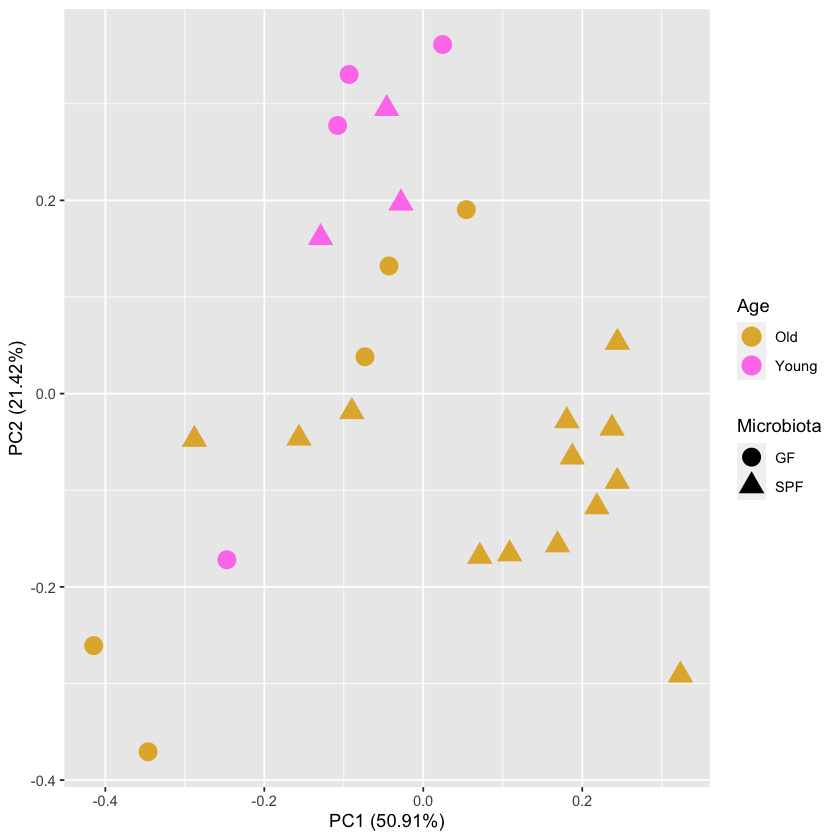

In [48]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', shape = 'Microbiota', size = 5) + 
    scale_color_manual(values = annot_colors$Age)

#### PC1 and PC3

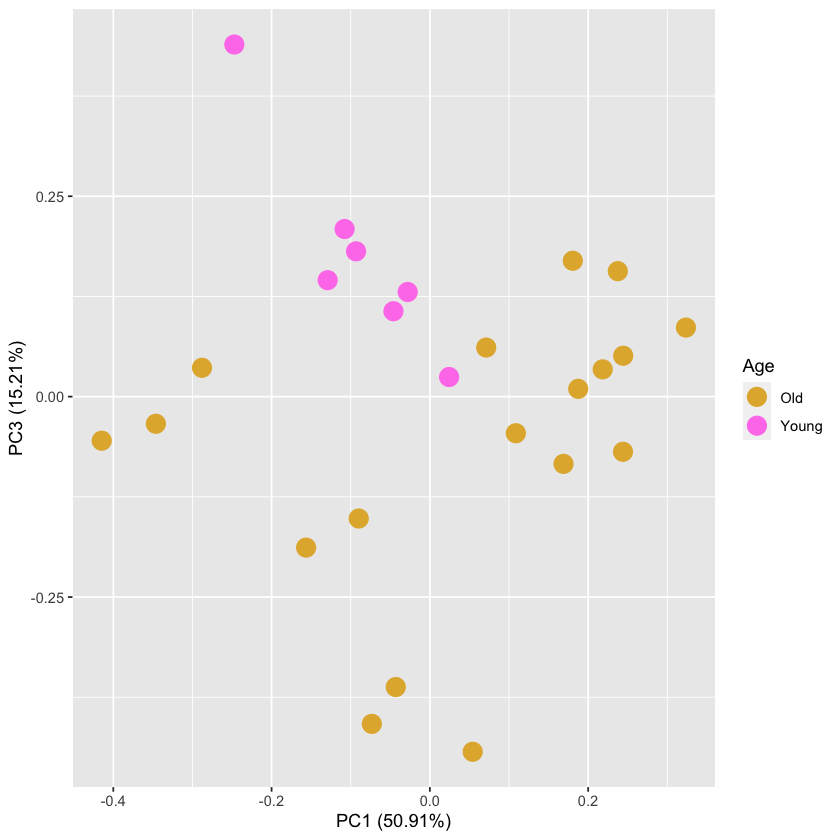

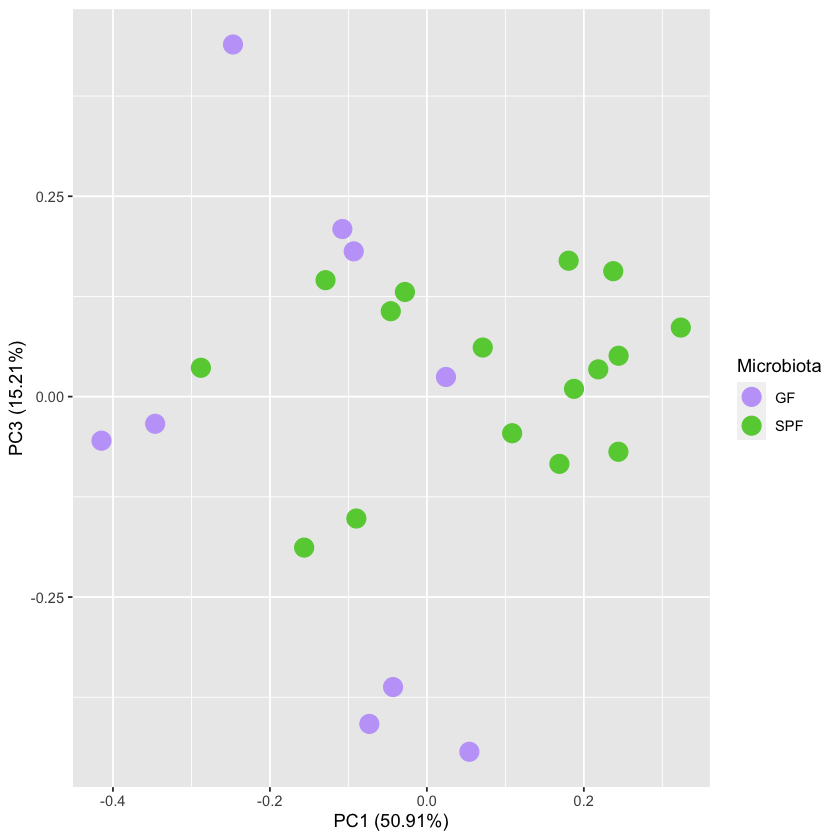

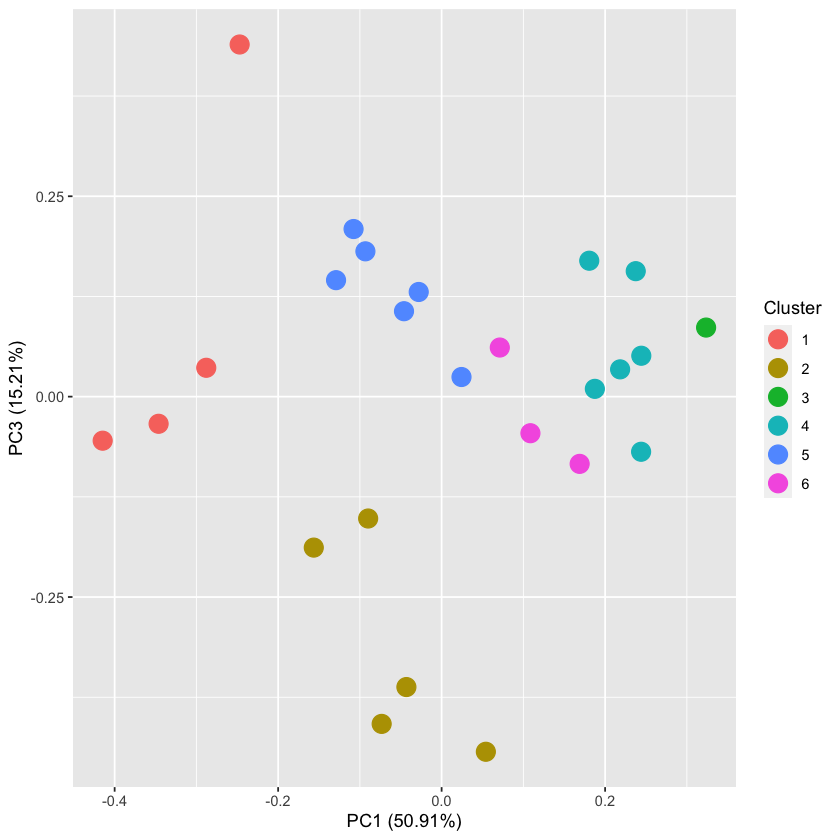

In [56]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', size = 5, x = 1, y = 3) + 
    scale_color_manual(values = annot_colors$Age)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Microbiota', size = 5, x = 1, y = 3) + 
    scale_color_manual(values = annot_colors$Microbiota)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', size = 5, x = 1, y = 3)

#### PC2 and PC3

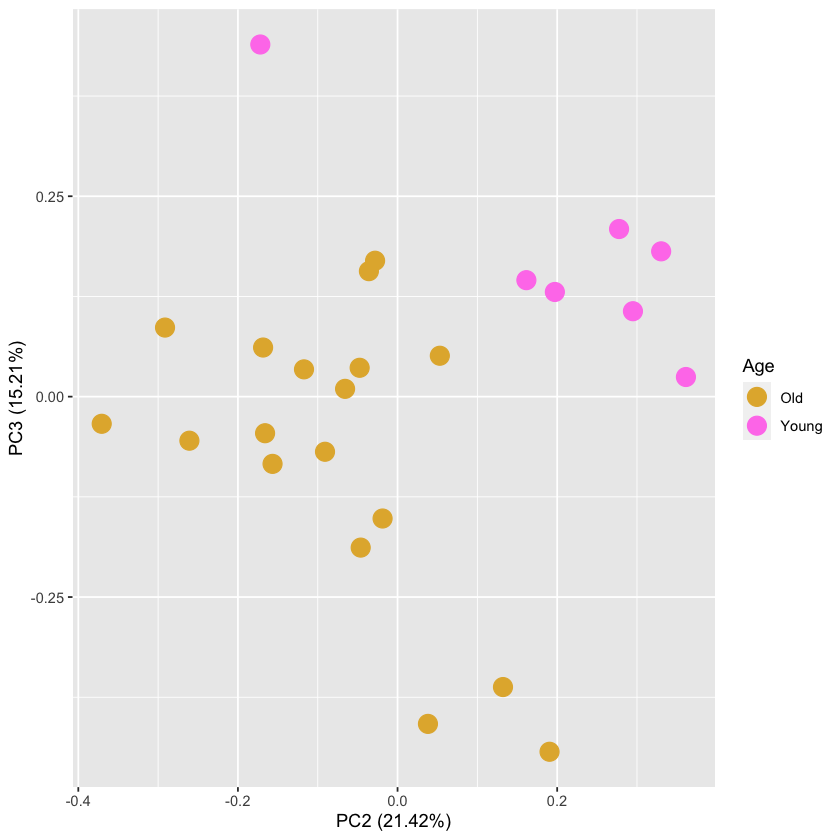

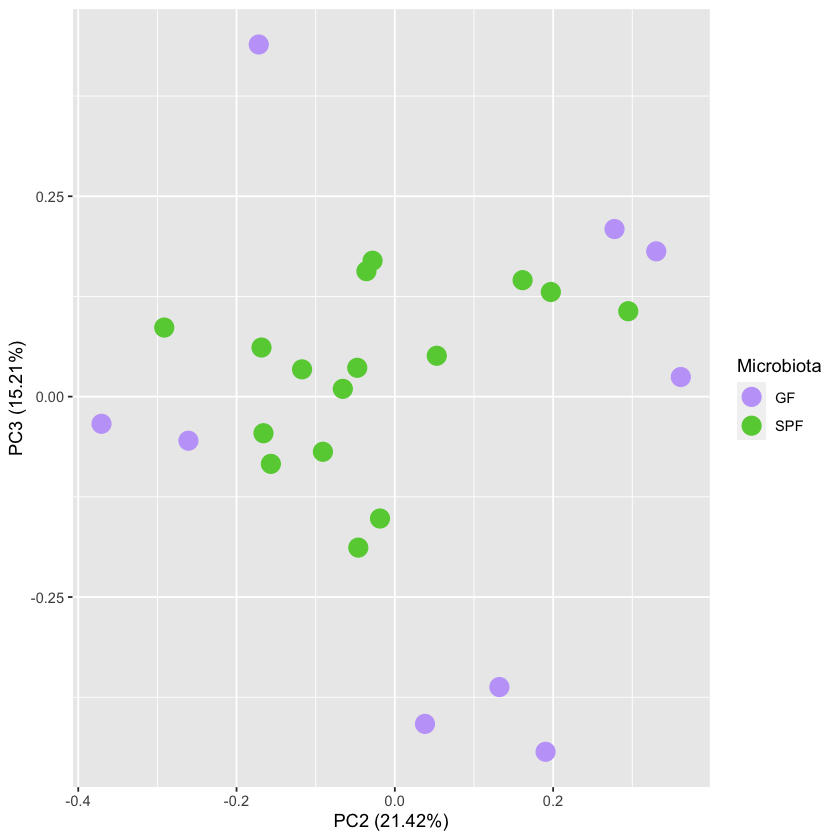

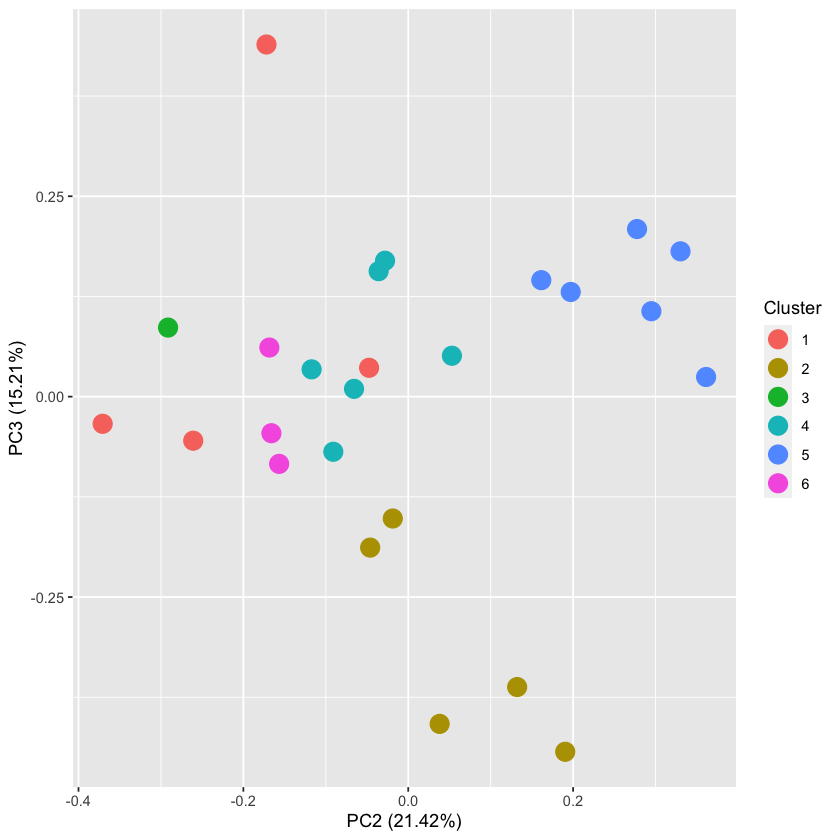

In [57]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', size = 5, x = 2, y = 3) + 
    scale_color_manual(values = annot_colors$Age)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Microbiota', size = 5, x = 2, y = 3) + 
    scale_color_manual(values = annot_colors$Microbiota)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', size = 5, x = 2, y = 3)

### GF vs SPF

In [58]:
plot_GF_SPF_PCA = function(a) {
    pca_metadata = metadata %>%
        filter(Age == a)
    pca_data = t(norm_counts)[pca_metadata$sample,]
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Microbiota', size = 6) + 
        scale_color_manual(values = annot_colors$Microbiota)
    dp = paste(plot_dp, "/female_male_pca/", sep='')
    dir.create(dp, showWarnings = FALSE)
    ggsave(paste(dp, a ,".pdf", sep=''))
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Microbiota', size = 6) + 
        scale_color_manual(values = annot_colors$Microbiota)
}

Young

Saving 7 x 7 in image



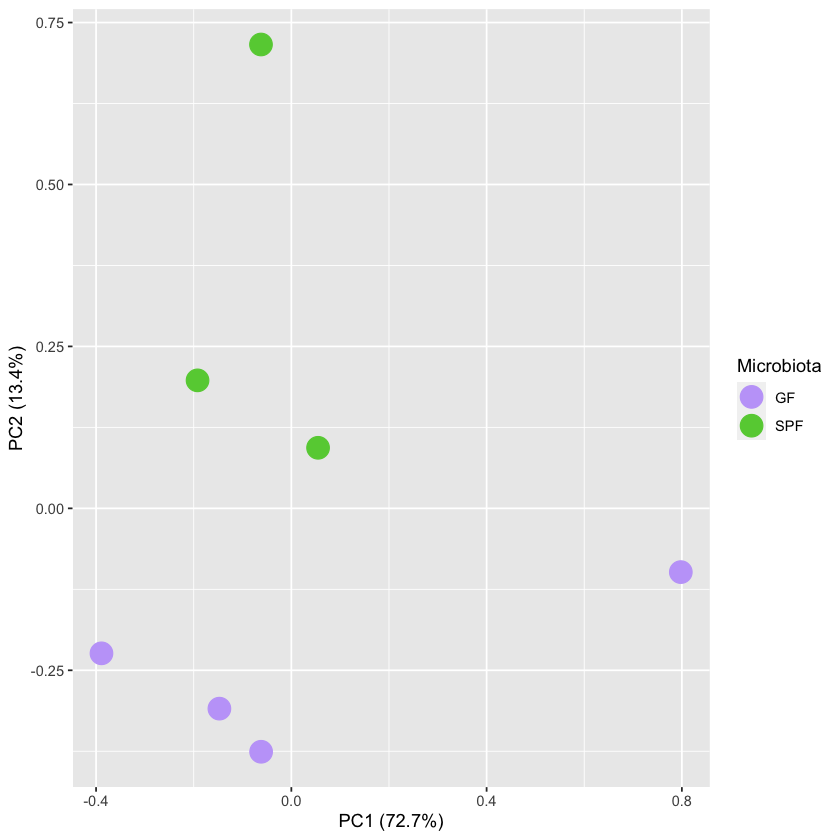

In [59]:
plot_GF_SPF_PCA('Young')

Old

Saving 7 x 7 in image



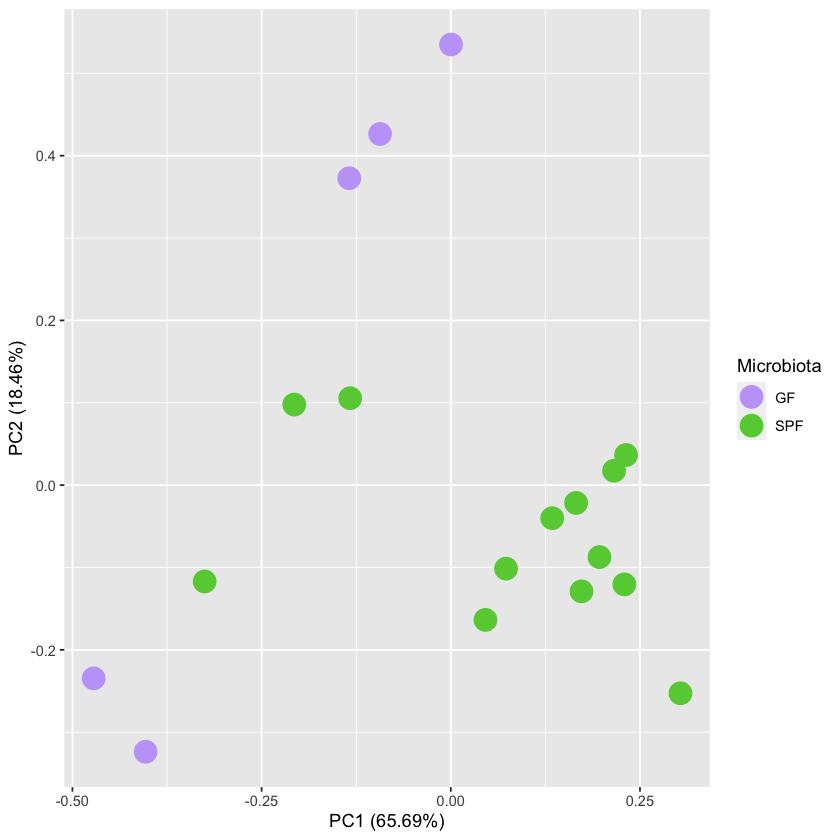

In [60]:
plot_GF_SPF_PCA('Old')

### Age

In [61]:
plot_age_PCA = function(m) {
    pca_metadata = metadata %>%
        filter(Microbiota == m)
    pca_data = t(norm_counts)[pca_metadata$sample,]
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Age', size = 6) + 
        scale_color_manual(values = annot_colors$Age)
    dp = paste(plot_dp, "/age_pca/", sep='')
    dir.create(dp, showWarnings = FALSE)
    ggsave(paste(dp, m ,".pdf", sep=''))
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Age', size = 6) + 
        scale_color_manual(values = annot_colors$Age)
}

SPF

Saving 7 x 7 in image



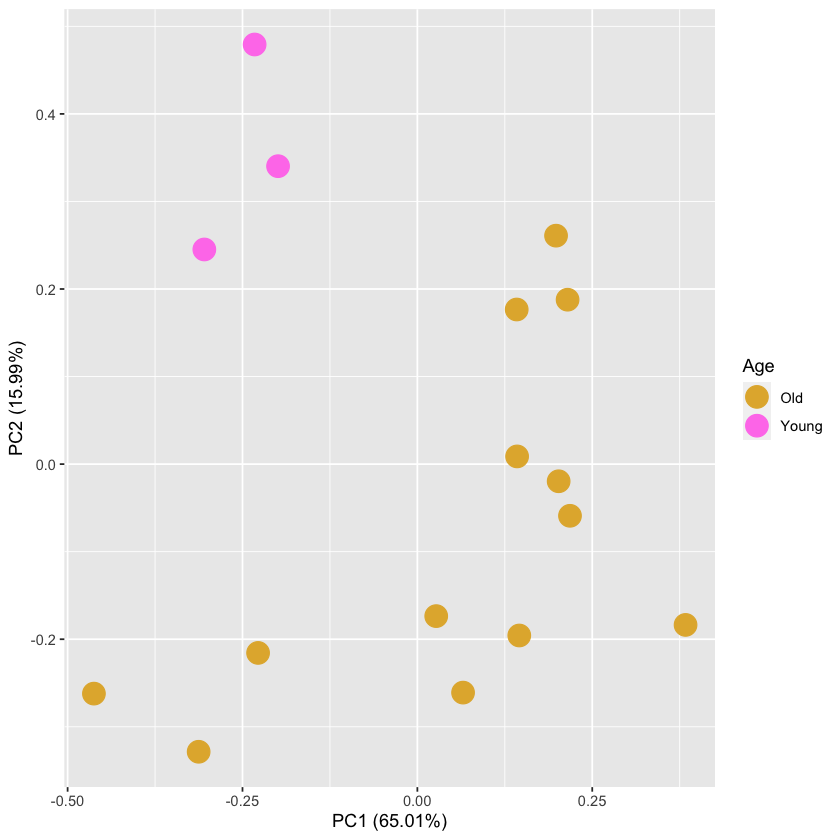

In [63]:
plot_age_PCA('SPF')

GF

Saving 7 x 7 in image



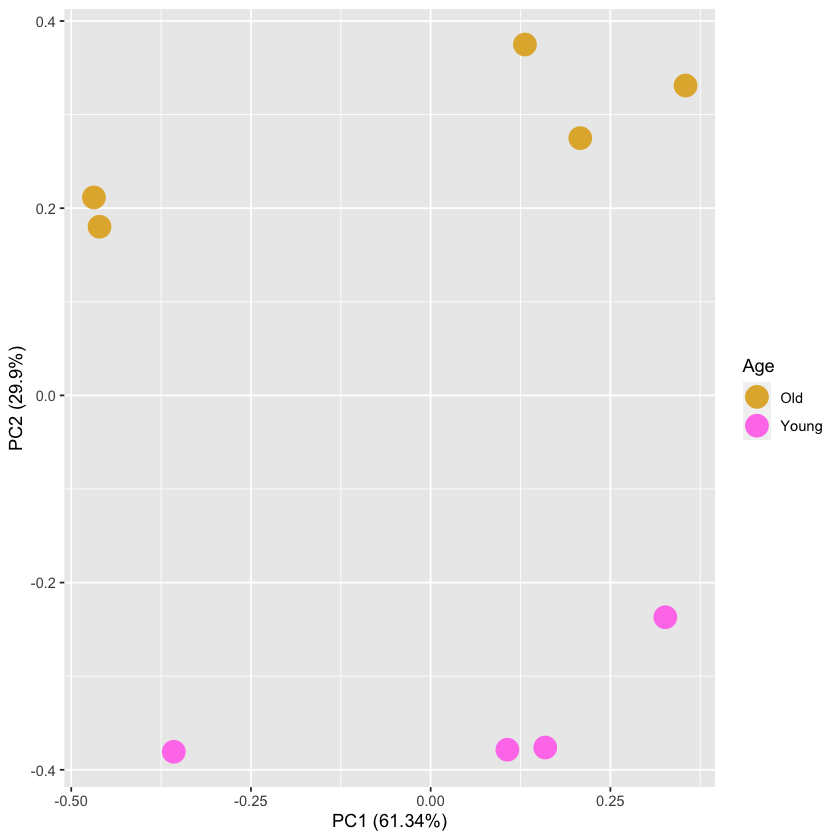

In [65]:
plot_age_PCA('GF')

# Z-scores (normalized counts) for all genes

## All genes

Column order: microbiota - age

pdf 
  2

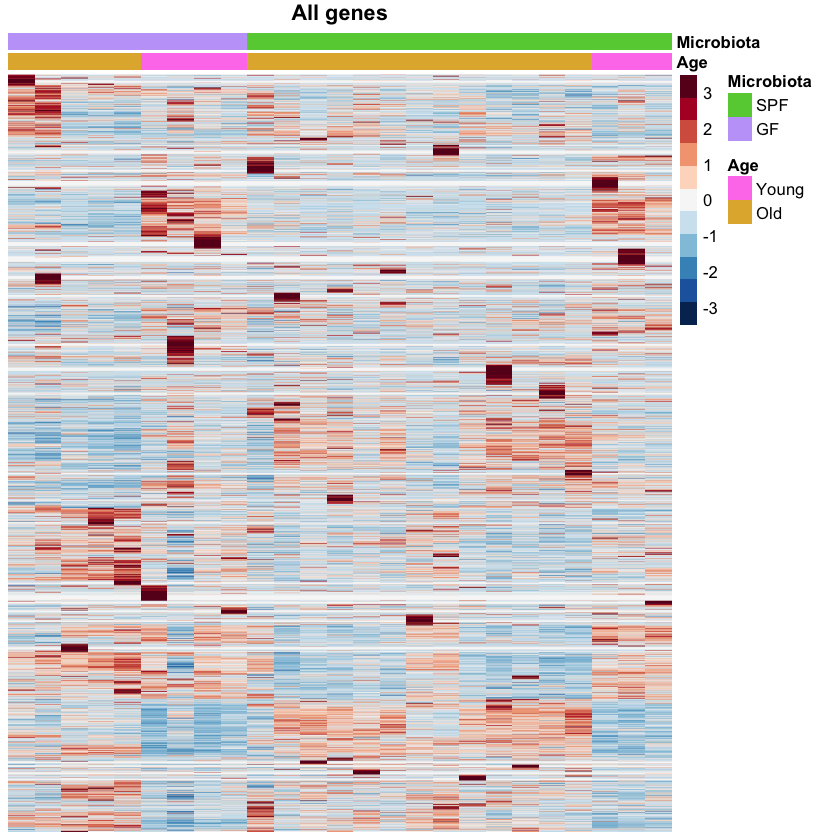

In [66]:
plot_z_score_heatmap(z_scores,
                     rownames(z_scores),
                     col_order$ma,
                     annot_col$ma,
                     "All genes",
                     col_order$ma,
                     fp=paste(plot_dp, "z_score_ma.pdf", sep=''))

### GF signature genes

In [67]:
genes = c(
    'Ero1lb', 'D16Ertd472e', 'Mcur1', 'Gpr137b-ps', 'Lonrf3', 'G530011O06Rik', 
    '1700112E06Rik', 'Ly86', 'Cd52', 'Sdc3', 'Dynlt1b', 'Tuba4a', 'Sult1a1', 
    'Notch4', 'Nnt', 'Plcd3', 'Rab4a', 'Wdfy1', 'Ctse', 'Gpr137b', 'Htra3')

Column order: microbiota - sex - age

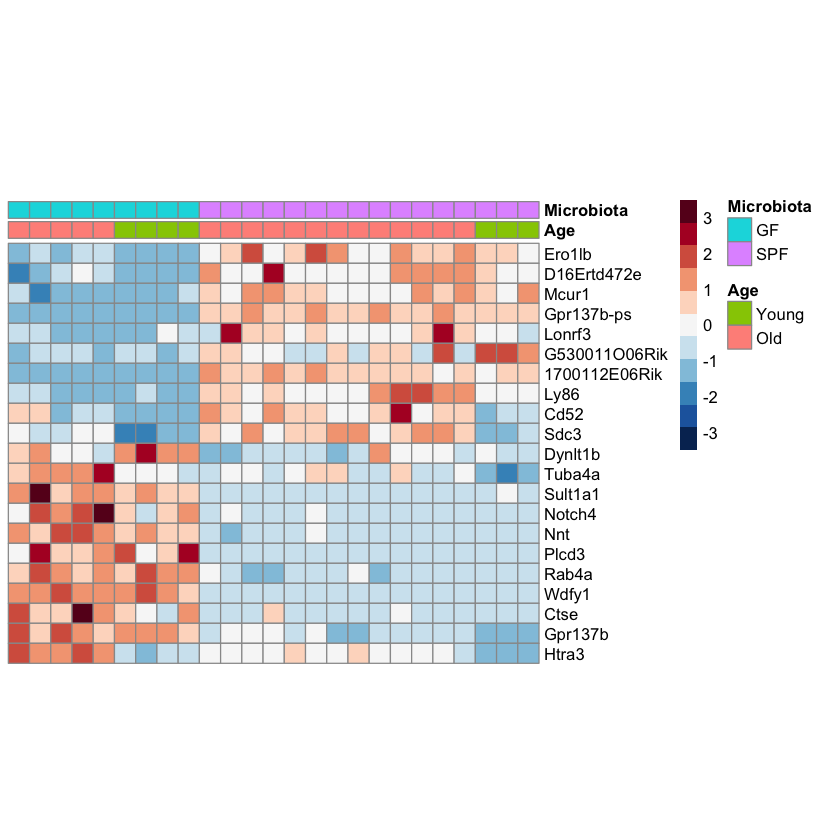

In [68]:
pheatmap(z_scores[genes,col_order$ma],
    cluster_rows=F,
    cluster_cols=F,
    show_rownames=T,
    show_colnames=F,
    annotation_col=annot_col$ma,
    annotation_row=NULL,
    annotation_colors = NULL,
    color=rev(brewer.pal(11, "RdBu")),
    breaks = seq(-3.5, 3.5, length=12),
    main ='', cellheight = 12)
pheatmap(z_scores[genes,col_order$ma],
    cluster_rows=F,
    cluster_cols=F,
    show_rownames=T,
    show_colnames=F,
    annotation_col=annot_col$ma,
    annotation_row=NULL,
    annotation_colors = NULL,
    color=rev(brewer.pal(11, "RdBu")),
    breaks = seq(-3.5, 3.5, length=12),
    main ='',
    cellheight = 12,
    filename=paste(plot_dp, "gf_signature_genes_z_scores.pdf"))

# Gene co-expression analysis

Weighted gene co-expression network analysis using WGCNA package

## Extract modules of co-expressed genes

Keep only genes that have a count >= 10 in more than 90% of the samples (number removed / kept displayed)

In [69]:
filtered_norm_counts = data.frame(original_norm_counts) %>%
    rownames_to_column('genes') %>%
    mutate(rowsum = rowSums(select(., -genes) >= 10)) %>%
    filter(rowsum >= 0.9*dim(original_norm_counts)[2]) %>%
    select(-rowsum) %>%
    filter(!genes %in% facs_genes) %>%
    filter(!genes %in% core_signature_genes$macrophage) %>%
    filter(!genes %in% core_signature_genes$monocyte) %>%
    filter(!genes %in% core_signature_genes$dc) %>%
    #filter(!genes %in% core_signature_genes$granulocyte) %>%
    filter(!genes %in% core_signature_genes$t) %>%
    filter(!genes %in% core_signature_genes$b) %>%
    filter(!genes %in% core_signature_genes$mast) %>%
    filter(!genes %in% core_signature_genes$nk) %>% 
    filter(!genes %in% c('Calm1')) %>% 
    select(-c(GF_8w_M_2_2, SPF_104w_M_3_2)) %>%
    column_to_rownames('genes')
dim(original_norm_counts)[1] - dim(filtered_norm_counts)[1]
dim(filtered_norm_counts)[1]

[1] 7879

[1] 10234

In [70]:
module_dp = paste(plot_dp, "modules/")
dir.create(module_dp, showWarnings = FALSE)

Analysis of scale free topology for multiple soft thresholding powers, with signed hybrid network type

pickSoftThreshold: will use block size 4371.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4371 of 10234
   ..working on genes 4372 through 8742 of 10234
   ..working on genes 8743 through 10234 of 10234
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0687  0.76          0.922 1320.00  1310.000 2030.0
2      2   0.2440 -0.93          0.894  515.00   492.000 1130.0
3      3   0.5440 -1.42          0.932  246.00   219.000  720.0
4      4   0.6890 -1.63          0.963  132.00   109.000  499.0
5      5   0.7510 -1.78          0.975   77.70    57.700  366.0
6      6   0.7970 -1.85          0.984   48.50    32.400  279.0
7      7   0.8170 -1.90          0.985   31.80    18.900  220.0
8      8   0.8360 -1.93          0.990   21.70    11.400  177.0
9      9   0.8450 -1.97          0.992   15.30     7.130  145.0
10    10   0.8580 -1.96          0.992   11.00     4.560  120.0
11    12   0.8690 -1.98          0.983   

Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0687169,0.7604949,0.9219060,1318.835780,1312.4895239,2027.26221
2,0.2439216,-0.9300034,0.8943591,515.342689,491.7553160,1126.83585
3,0.5443924,-1.4190002,0.9315924,245.636040,219.2897219,720.31400
4,0.6889857,-1.6273182,0.9630650,132.381550,108.8040094,498.78499
5,0.7509202,-1.7765609,0.9749345,77.669926,57.6800014,365.81567
6,0.7965464,-1.8452035,0.9837522,48.523466,32.3846159,279.27267
7,0.8174292,-1.9044533,0.9853142,31.822926,18.9336540,219.60712
8,0.8363514,-1.9317959,0.9902391,21.695832,11.4408679,176.60328
9,0.8448553,-1.9668284,0.9917385,15.269036,7.1252273,144.60278


,Power,mean.k.
,<dbl>,<dbl>
7,7,31.822926
8,8,21.695832
9,9,15.269036
10,10,11.035059
11,12,6.147444
12,14,3.665486
13,16,2.304202
14,18,1.511159
15,20,1.026149


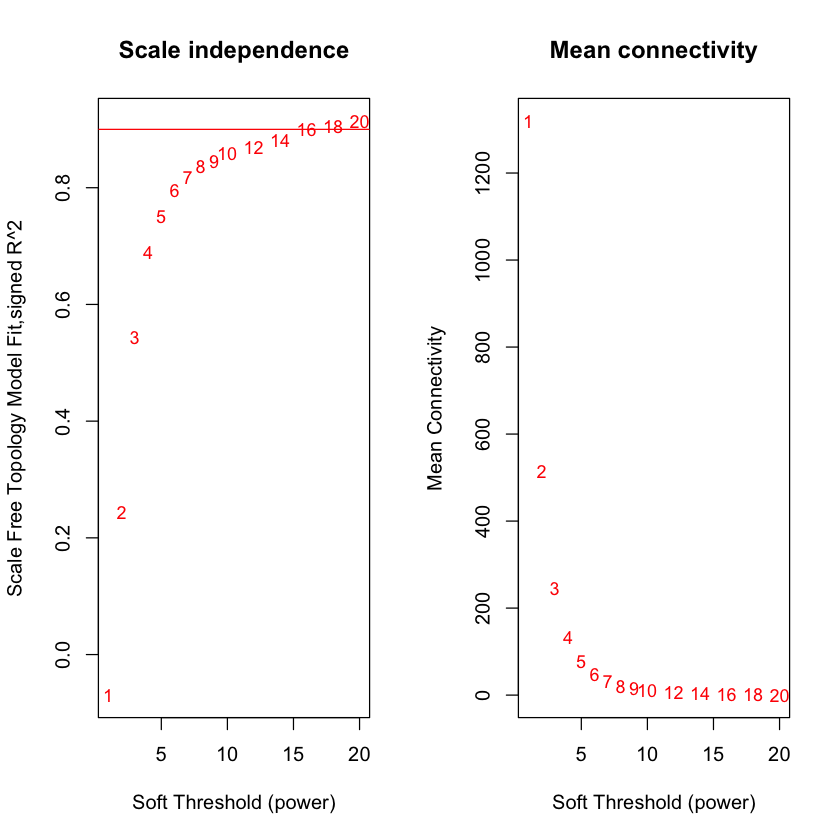

In [71]:
networkType = "signed hybrid"
powers = c(seq(1, 10, by = 1), seq(12, 20, by = 2))
# Choosing the soft-thresholding power
sft = pickSoftThreshold(t(filtered_norm_counts),
                        powerVector = powers,
                        dataIsExpr = T,
                        RsquaredCut = 0.85,
                        verbose = 5,
                        networkType = "signed hybrid")
par(mfrow = c(1,2))
cex1 = 0.9
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1],
     -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1],
     -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,
     cex=cex1,
     col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1],
     sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
sft$fitIndices
sft$fitIndices[(-sign(sft$fitIndices[,3])*sft$fitIndices[,2])>=0.8,c(1,5)]

Block-wise network construction and module detection
- Soft-thresholding power parameter: 5 (R2 > 0.80 and mean connectivity highest as possible (Ref: https://www.degruyter.com/view/j/sagmb.2005.4.issue-1/sagmb.2005.4.1.1128/sagmb.2005.4.1.1128.pdf))
- Minimum module size: 65
- Height for module merging: 0.35 (below)
- Biweight Midcorrelation

In [72]:
soft_thresholding_power = 15
min_module_size = 65
mergeCutHeight = 0.35
# Block-wise network construction and module detection
bwnet = blockwiseModules(t(filtered_norm_counts),
                 checkMissingData = TRUE,
                 maxBlockSize = 11000,
                 power = soft_thresholding_power,
                 networkType = networkType,
                 TOMType = "signed",
                 numericLabels = TRUE,
                 saveTOMs = TRUE,
                 saveTOMFileBase = "norm_genes_TOM",
                 mergeCutHeight = mergeCutHeight, 
                 verbose=3,
                 corType="bicor",
                 maxPOutliers=0,
                 minModuleSize = min_module_size,
                 reassignThreshold = 0,
                 deepSplit = 2)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 4 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file norm_genes_TOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 56 genes from module 1 because their KME is too low.
     ..removing 47 genes from module 2 because their KME is too low.
     ..removing 32 genes from module 3 because their KME is too low.
     ..removing 41 genes from module 4 because their KME is too low.
     ..removing 12 genes from module 5 because their KME is too low.
     ..removing 24 genes from module 6 because their KME is too low.
     ..removing 15 genes from module 7 b

Size of the modules (ME0: genes not assigned to a module) and number of genes in modules

In [73]:
# Modules
mod_sizes = table(bwnet$colors)
names(mod_sizes) = paste("ME", names(mod_sizes), sep="")
mod_sizes
module_nb = dim(table(bwnet$colors))-1
# Get genes that are in one module
mod_genes = rownames(filtered_norm_counts)[bwnet$colors>0]

 ME0  ME1  ME2  ME3  ME4  ME5  ME6  ME7  ME8  ME9 ME10 ME11 ME12 ME13 
1292 2242 1215  957  896  858  789  543  530  289  211  190  144   78 

Dendrogram and the module colors underneath the block

pdf 
  2

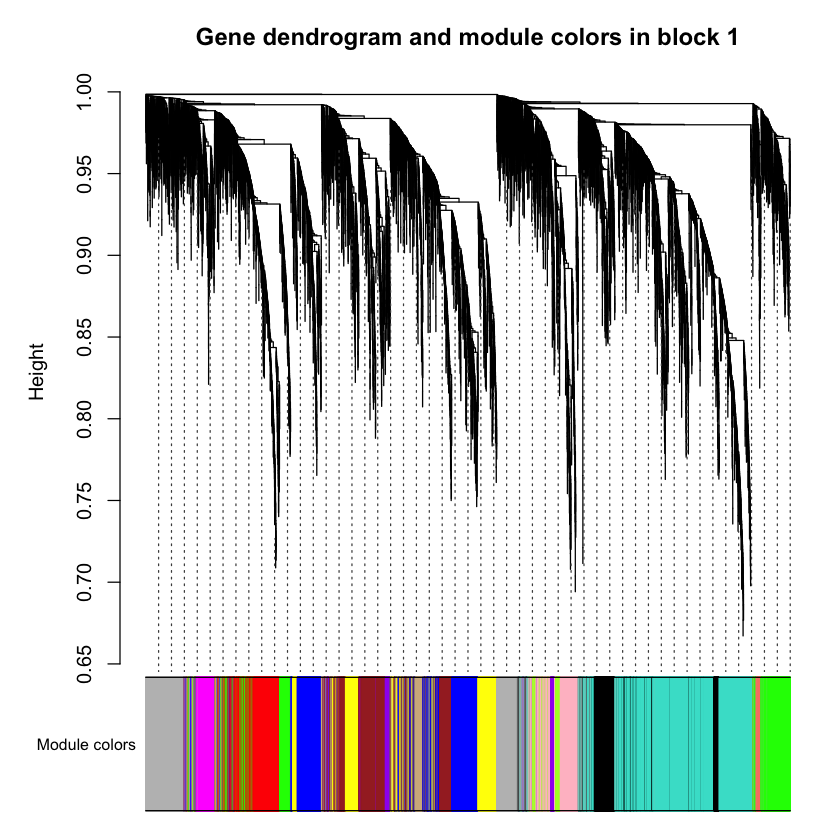

In [74]:
bwModuleColors = labels2colors(bwnet$colors)
plotDendroAndColors(bwnet$dendrograms[[1]],
                    bwModuleColors[bwnet$blockGenes[[1]]],
                    "Module colors",
                    main = "Gene dendrogram and module colors in block 1",
                    dendroLabels = FALSE,
                    hang = 0.03,
                    addGuide = TRUE,
                    guideHang = 0.05)
pdf(paste(module_dp, "gene_dendogram_module_colors.pdf", sep=''))
plotDendroAndColors(bwnet$dendrograms[[1]],
                    bwModuleColors[bwnet$blockGenes[[1]]],
                    "Module colors",
                    main = "Gene dendrogram and module colors in block 1",
                    dendroLabels = FALSE,
                    hang = 0.03,
                    addGuide = TRUE,
                    guideHang = 0.05)
dev.off()

Associate module color to genes

In [75]:
gene_colors = bwnet$colors
names(gene_colors) = rownames(filtered_norm_counts)
head(gene_colors)

0610007P14Rik 0610009B22Rik 0610009L18Rik 0610009O20Rik 0610010F05Rik 
            1             1             5             2             1 
0610010K14Rik 
            9

Recalculate MEs with color labels

In [76]:
MEs = moduleEigengenes(t(filtered_norm_counts), gene_colors)$eigengenes

Extract the palette for next plots

In [77]:
pal2 = labels2colors(sort(unique(bwnet$colors)))
names(pal2) = names(mod_sizes)
pal2
save(pal2, file = paste(dp, "dge_net_pal2.RData", sep=''))

ME0           ME1           ME2           ME3           ME4 
       "grey"   "turquoise"        "blue"       "brown"      "yellow" 
          ME5           ME6           ME7           ME8           ME9 
      "green"         "red"       "black"        "pink"     "magenta" 
         ME10          ME11          ME12          ME13 
     "purple" "greenyellow"         "tan"      "salmon"

## Relationship between modules and samples

Module-trait correlation analysis between the module eigengene (ME) and the different trait (combination of Microbiota, age and sex)
- correlation of Pearson between each pair of variables
- Student asymptotic p-values for the correlations

In [78]:
plot_module_groups = function(trait, vertsep){
    trait = trait %>% select(-c(sample))
    # Calculate correlation
    moduleTraitCor = cor(MEs, trait, use = "p")
    moduleTraitPvalue = corPvalueStudent(moduleTraitCor, dim(filtered_norm_counts)[2])
    # Will display correlations and their p-values
    textMatrix = paste(signif(moduleTraitCor, 2), "\n(",signif(moduleTraitPvalue, 1), ")", sep = "")
    dim(textMatrix) = dim(moduleTraitCor)
    # Plot correlation
    par(mar = c(6, 8.5, 3, 3))
    labeledHeatmap(Matrix = moduleTraitCor,
                    xLabels = colnames(trait),
                    ySymbols = paste(names(mod_sizes), " \n(", mod_sizes, " genes)", sep = ""),
                    yLabels = paste('ME', pal2, sep=''),
                    colorLabels = FALSE,
                    yColorLabels = TRUE,
                    colors = rev(brewer.pal(11, "RdBu")),
                    textMatrix = textMatrix,
                    setStdMargins = FALSE,
                    cex.text = 0.5,
                    cex.lab.y = .75,
                    zlim = c(-1,1),
                    verticalSeparator.x = vertsep)
}

In [79]:
plot_module_groups(trait[['Groups']], 3)

ERROR: Error in cor(MEs, trait, use = "p"): 'x' and 'y' have incompatible dimensions (unequal numbers of rows).


In [ ]:
plot_module_groups(trait[['Microbiota / Age']], 3)
pdf(paste(module_dp, "module_group_microbiota_age.pdf", sep=''))
plot_module_groups(trait[['Microbiota / Age']], 3)
dev.off()

In [ ]:
plot_module_groups(trait[['Age / Microbiota']], c(2, 4))
pdf(paste(module_dp, "module_group_age_microbiota.pdf", sep=''))
plot_module_groups(trait[['Age / Microbiota']], c(2, 4))
dev.off()
apply(trait[['Age / Microbiota']] %>% select(-c(sample)),2, sum)

## Genes in modules

Associate genes to modules

In [ ]:
genes_in_modules_bool = sapply(0:module_nb, function(x) return(gene_colors == x))
colnames(genes_in_modules_bool) = names(mod_sizes)

In [ ]:
head(gene_colors)

In [ ]:
genes_in_modules = lapply(names(mod_sizes), function(x) return(rownames(genes_in_modules_bool[genes_in_modules_bool[,x],])))
names(genes_in_modules) = names(mod_sizes)
capture.output(genes_in_modules, file = paste(module_dp, "genes_in_modules", sep=''))
save(genes_in_modules, file=paste(dp, "genes_in_modules.RData", sep=''))

In [ ]:
gene_modules = data.frame(genes = names(gene_colors), module=gene_colors)
write.table(gene_modules, file=paste(module_dp, "genes_in_modules.tsv", sep=''), sep='\t', quote=FALSE, row.names = FALSE)

### Heatmaps with Z-scores

#### Microbiota  / Age

In [ ]:
for(x in names(mod_sizes)){
    plot_z_score_heatmap(z_scores,
                         genes_in_modules[[x]],
                         col_order$ma,
                         annot_col$ma,
                         paste("Genes in ", x, sep=""),
                         col_order$sa,
                         fp=paste(module_dp, "module_heatmap", x, ".pdf", sep=""))
}

#### Age  / Microbiota

In [ ]:
for(x in names(mod_sizes)){
    plot_z_score_heatmap(z_scores,
                         genes_in_modules[[x]],
                         col_order$am,
                         annot_col$am,
                         paste("Genes in ", x, sep=""),
                         col_order$am)
}

### Sinaplots of the Z-scores per groups

The mean of the Z-score over the samples in the group is plot for each gene

In [ ]:
plot_z_score_sinaplot = function(g, trait, z_scores, module_nb, genes_in_modules, pdf = FALSE){
    g_trait = trait[[g]]
    for(x in names(mod_sizes)){
        genes_in_mod = genes_in_modules[[x]]
        z_scores_vec = c()
        groups = c()
        for(y in colnames(g_trait)[-1]){
            samples = g_trait %>% 
                filter((!!as.name(y)) == 1) %>%
                pull(sample)
            mean_z_scores = apply(z_scores[genes_in_mod, samples], 1, mean)
            z_scores_vec = c(z_scores_vec, mean_z_scores)
            groups = c(groups, rep(y, length(mean_z_scores)))
        }
        sinaplot(z_scores_vec, 
                 groups,
                 col=pal2[x],
                 pch = 20,
                 bty = "n",
                 main=paste("Z-scores for the ", mod_sizes[x], " genes in ", x, sep=""),
                 las=2,
                 ylab = "Mean Z-scores of the genes over samples",
                 cex.axis=0.75)
        if(pdf){
            pdf(paste(module_dp, "module_sinaplot_", x, ".pdf", sep=""))
            sinaplot(z_scores_vec, 
                     groups,
                     col=pal2[x],
                     pch = 20,
                     bty = "n",
                     main = paste("Z-scores for genes in ", x, sep=""),
                     las=2,
                     ylab = "Mean Z-scores of the genes over samples",
                     cex.axis=0.75)
            dev.off()
        }
    }
}

#### Microbiota / Age

In [ ]:
plot_z_score_sinaplot('Microbiota / Age', trait, z_scores, module_nb, genes_in_modules)

#### Age / Microbiota

In [ ]:
plot_z_score_sinaplot('Age / Microbiota', trait, z_scores, module_nb, genes_in_modules)

### Selected genes in modules

In [ ]:
selected_genes = c('Ash1l', 'Ddit4', 'Cadm1', 'Axl', 'Atad2b', 'Gpd1', 'Capg', 'Ccl12', 'Atm', 'Ezr', 'Cd22',
                   'Cxcl10', 'Atr', 'Klf2', 'Cd81', 'Cd180', 'Atxn7', 'Per1', 'Crlf2', 'Fgr', 'Cep350', 
                   'Pid1', 'Emp2', 'Hif1a', 'Cep95', 'Rgs1', 'Gsn', 'Ifit2', 'Chd2', 'Tmod1', 'H2-m3', 'Il1b',
                   'Huwe1', 'Trpv4', 'H2-dma', 'Il6st', 'Kmt2c', 'Fkbp5', 'Ly9', 'Ldlr', 'Lyst', 'Slc1a5', 
                   'Tnfsf13b', 'Stat1', 'Mapk8', 'Tnfsf10', 'Tlr2', 'Lyst', 'Tnfsf8', 'Mapk8', 'Mga', 'Setd2',
                   'Srcap', 'Tet2', 'Ubr4')

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in modules",
    show_rownames=TRUE,
    fp=paste(module_dp, "selected_genes_in_modules.pdf", sep=''))

In [ ]:
ME7_ME8_genes = c(genes_in_modules$ME7, genes_in_modules$ME8)
selected_genes_in_ME7_ME8 = selected_genes[selected_genes %in% ME7_ME8_genes]

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes_in_ME7_ME8,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in ME7 and ME8",
    show_rownames=TRUE)

In [ ]:
additional_selected_genes = read.csv("../../data/additional_selected_genes_modules.txt", sep="\t")

In [ ]:
selected_genes = c(selected_genes, additional_selected_genes$Genes)

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in modules",
    show_rownames=TRUE,
    fp=paste(module_dp, "selected_genes_in_modules_2.pdf", sep=''),
    fontsize_row=6)

In [ ]:
ME7_ME8_genes = c(genes_in_modules$ME7, genes_in_modules$ME8)
selected_genes_in_ME7_ME8 = selected_genes[selected_genes %in% ME7_ME8_genes]

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes_in_ME7_ME8,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in ME7 and ME8",
    show_rownames=TRUE)

### Genes related to ROS

List of genes extracted from AmiGO, filtered on mouse and contributor to MGI

#### Genes in GO:0000302 (Response to reactive oxygen species)

In [ ]:
GO_0000302_ROS_genes = read.table(
    "../../data/GO_0000302_ROS_genes.txt", 
    h = F,
    sep='\t',
    col.names=c("Name", "Description", "MGI id"))

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    GO_0000302_ROS_genes$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in GO:0000302")

#### Genes in GO:2000377 (Regulation of reactive oxygen species metabolic process)

In [ ]:
GO_2000377_ROS_genes = read.table(
    "../../data/GO_2000377_ROS_genes.txt", 
    h = F,
    sep='\t',
    col.names=c("Name", "Description", "MGI id"))

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    GO_2000377_ROS_genes$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in GO:2000377")

#### Genes in both GO:0000302 and GO:2000377

In [ ]:
ROS_genes = rbind(GO_0000302_ROS_genes, GO_2000377_ROS_genes)

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377")

Only for genes in ME7 and ME8

In [ ]:
ME7_ME8_genes = c(genes_in_modules$ME7, genes_in_modules$ME8)
ROS_genes_in_ME7_ME8 = ROS_genes %>%
    filter(Name %in% ME7_ME8_genes)

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes_in_ME7_ME8$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377",
    show_rownames=TRUE,
    fp=paste(module_dp, 'ros_genes_me7_me8.pdf', sep=''))

Only for genes in ME2, ME7 and ME8

In [ ]:
MEs_genes = c(genes_in_modules$ME2, genes_in_modules$ME7, genes_in_modules$ME8)
ROS_genes_in_MEs = ROS_genes %>%
    filter(Name %in% MEs_genes)

In [ ]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes_in_MEs$Name,
    col_order$msa,
    annot_col$msa,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377",
    show_rownames=TRUE,
    fp=paste(module_dp, 'ros_genes_mes.pdf', sep=''),
    fontsize_row=8)

## Enrichment analysis in modules

In [ ]:
x = names(mod_sizes)[1]
pwf = suppressMessages(nullp(genes_in_modules_bool[, x], 'mm10', 'geneSymbol', plot.fit=F)) 

In [ ]:
for(x in names(mod_sizes)){
    print(x)
    pwf = suppressMessages(nullp(genes_in_modules_bool[, x], 'mm10', 'geneSymbol', plot.fit=F))                        
    GO_wall = goseq(pwf, 'mm10', 'geneSymbol')
    adj_GO_wall = GO_wall[p.adjust(GO_wall[,"over_represented_pvalue"], method="BH")<.05,]
    print(head(adj_GO_wall[adj_GO_wall$ontology == "BP",]))
    write.table(adj_GO_wall, paste(module_dp, x, "_GO", sep=""), sep = "\t", quote = FALSE, row.names = FALSE)    
}

# Citations

In [ ]:
citation("WGCNA")

In [ ]:
citation("sinaplot")
toBibtex(citation("sinaplot"))

In [ ]:
citation("goseq")

In [ ]:
citation("org.Mm.eg.db")